In [1]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

In [2]:
MODEL_1 = "finetuned"
MODEL_2 = "irishman"

SET_1_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_1)
SET_2_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_2)

ABSOLUTE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/absolute_metrics_statistics.pkl".format(MODEL_1, MODEL_2)
RELATIVE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/relative_metrics_statistics.pkl".format(MODEL_1, MODEL_2)

## Results finetuned vs irishman

Load calculated metrics for each model

In [3]:
with open(SET_1_CALCULATED_METRICS_PATH, "rb") as f:
    set1_loaded_results = pickle.load(f)

with open(SET_2_CALCULATED_METRICS_PATH, "rb") as f:
    set2_loaded_results = pickle.load(f)

display("Set 1 ({}): {} samples".format(MODEL_1, len(set1_loaded_results)))
display("Set 2 ({}): {} samples".format(MODEL_2, len(set2_loaded_results)))

u'Set 1 (finetuned): 9 samples'

u'Set 2 (irishman): 9 samples'

We calculated the following metrics:

**Pitch-based features**
- total_used_pitch
- total_pitch_class_histogram
- pitch_class_transition_matrix
- pitch_range
- avg_pitch_shift

**Rhythm-based features**
- total_used_note
- avg_IOI
- note_length_hist
- note_length_transition_matrix

In [4]:
display(set1_loaded_results.keys())

['total_used_note',
 'note_length_transition_matrix',
 'total_pitch_class_histogram',
 'total_used_pitch',
 'avg_IOI',
 'avg_pitch_shift',
 'pitch_range',
 'pitch_class_transition_matrix',
 'note_length_hist']

# Pitch-based features

## Feature: `total_used_pitch`

### O que faz:
Esta fun√ß√£o conta quantas alturas (pitches) diferentes foram utilizadas em uma m√∫sica MIDI, medindo a diversidade mel√≥dica.

### Como funciona (passo a passo):
1. `piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)`
    - Converte o MIDI em uma matriz piano roll (128 x tempo)
    - 128 linhas = todas as notas poss√≠veis (C0 at√© G9)
    - Cada coluna = um momento no tempo (100 fps)
    - Valores > 0 = nota est√° sendo tocada
    
2. `sum_notes = np.sum(piano_roll, axis=1)`
    - Soma cada linha (pitch) ao longo do tempo
    - Resultado: vetor de 128 elementos
    - Cada elemento = tempo total que aquela nota foi tocada

3. `used_pitch = np.sum(sum_notes > 0)`
    - Conta quantas notas tiveram sum > 0
    - Ou seja: quantas alturas diferentes foram usadas na m√∫sica

### Exemplo pr√°tico:
```
Se uma m√∫sica usa as notas: C4, D4, C4, E4, D4, C4, E3

piano_roll teria valores > 0 apenas nas linhas 52, 60, 62, 64 (MIDI numbers)

sum_notes[52] = tempo total de E3
sum_notes[60] = tempo total de C4
sum_notes[62] = tempo total de D4  
sum_notes[64] = tempo total de E4
sum_notes[outros] = 0

Resultado: total_used_pitch = 4 (quatro alturas diferentes)
```

### Ponto importante:
A fun√ß√£o conta alturas √∫nicas, n√£o repeti√ß√µes:

- **C4 repetido 3x** = conta como 1 altura √∫nica
- **D4 repetido 2x** = conta como 1 altura √∫nica
- **E4 usado 1x** = conta como 1 altura √∫nica
- **E3 usado 1x** = conta como 1 altura √∫nica

**Total = 4 alturas diferentes**

### Diferen√ßa importante:
**total_used_pitch**: Quantas alturas diferentes (foco mel√≥dico)
**total_used_note**: Quantos eventos de nota (foco r√≠tmico)
**total_pitch_class_histogram**: Propor√ß√£o de cada classe (C, C#, D...)

### Interpreta√ß√£o musical:
- **Valores baixos (5-15)**: Melodias simples, poucas notas diferentes
- **Valores m√©dios (20-40)**: Melodias moderadamente complexas
- **Valores altos (50+)**: Melodias muito diversas, muitas alturas diferentes

Esta m√©trica √© √∫til para comparar a riqueza mel√≥dica entre os modelos.

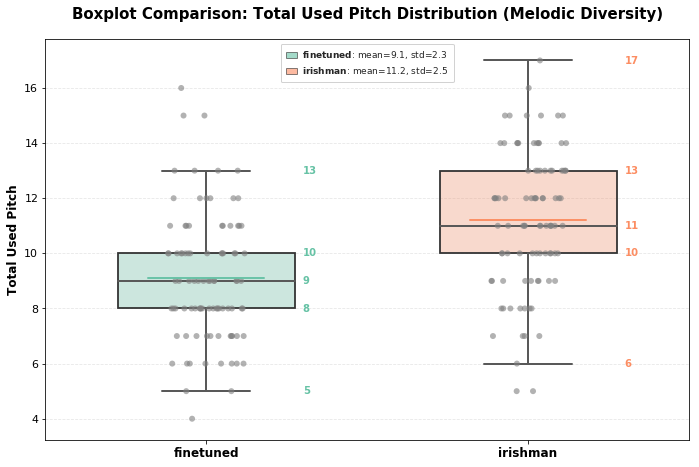

In [5]:
# Dados para total_used_pitch
data1_pitch = set1_loaded_results['total_used_pitch'].flatten()
data2_pitch = set2_loaded_results['total_used_pitch'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e r√≥tulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df_pitch = pd.DataFrame({
    'value': np.concatenate([data1_pitch, data2_pitch]),
    'model': np.array([labels[0]] * len(data1_pitch) + [labels[1]] * len(data2_pitch))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df_pitch, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df_pitch[df_pitch['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da m√©dia com a cor do box (acima dos pontos)
means_pitch = df_pitch.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means_pitch[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats_pitch = df_pitch.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df_pitch.loc[df_pitch['model'] == lbl, 'value'].values
    q1 = float(qstats_pitch.loc[lbl, 0.25])
    med = float(qstats_pitch.loc[lbl, 0.50])
    q3 = float(qstats_pitch.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme defini√ß√£o do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anota√ß√µes num√©ricas √† direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda centralizada no topo em 2 linhas
stds_pitch = df_pitch.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats_pitch = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means_pitch[labels[0]]), float(stds_pitch[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means_pitch[labels[1]]), float(stds_pitch[labels[1]]))
]
handles_pitch = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
                 Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles_pitch, label_stats_pitch, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X sim√©tricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# R√≥tulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Pitch', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Pitch Distribution (Melodic Diversity)', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

# Feature: `total_pitch_class_histogram`

## Vis√£o Geral

A fun√ß√£o `total_pitch_class_histogram` (linha 169) calcula um **histograma de classes de altura** (pitch class histogram) para um arquivo MIDI. Esta fun√ß√£o cria uma representa√ß√£o independente de oitava do conte√∫do harm√¥nico da m√∫sica.

## Prop√≥sito

Quantifica a frequ√™ncia de uso de cada uma das 12 notas da escala crom√°tica:
- **0**: D√≥
- **1**: D√≥#/R√©b  
- **2**: R√©
- **3**: R√©#/Mib
- **4**: Mi
- **5**: F√°
- **6**: F√°#/Solb
- **7**: Sol
- **8**: Sol#/L√°b
- **9**: L√°
- **10**: L√°#/Sib
- **11**: Si

## Par√¢metros

- **`feature`**: Dicion√°rio contendo um objeto `pretty_midi`

## Retorno

Array NumPy de 12 elementos representando a propor√ß√£o de tempo que cada classe de altura foi utilizada na m√∫sica (normalizado para somar 1).

## Como Funciona

### 1. Convers√£o para Piano Roll
```python
piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
```
- Converte o MIDI em representa√ß√£o "piano roll" com frequ√™ncia de amostragem de 100Hz
- Matriz onde cada linha representa uma nota MIDI (0-127) e cada coluna um momento no tempo

### 2. Inicializa√ß√£o do Histograma
```python
histogram = np.zeros(12)
```
- Cria array de 12 posi√ß√µes (uma para cada classe de altura)

### 3. C√°lculo das Classes de Altura
```python
for i in range(0, 128):
    pitch_class = i % 12
    histogram[pitch_class] += np.sum(piano_roll, axis=1)[i]
```
- Para cada nota MIDI (0-127), calcula sua classe de altura usando m√≥dulo 12
- **Exemplo**: 
  - Nota 60 (D√≥ central) ‚Üí `60 % 12 = 0`
  - Nota 72 (D√≥ uma oitava acima) ‚Üí `72 % 12 = 0`
- Soma a dura√ß√£o total dessa nota ao longo de toda a m√∫sica
- Acumula no histograma da classe de altura correspondente

### 4. Normaliza√ß√£o
```python
histogram = histogram / sum(histogram)
```
- Normaliza o histograma para criar uma distribui√ß√£o de probabilidade (soma = 1)

## Aplica√ß√µes

Esta m√©trica √© √∫til para:
- **An√°lise harm√¥nica**: Identificar quais notas s√£o mais predominantes
- **Identifica√ß√£o de tonalidade**: Padr√µes podem indicar a tonalidade da m√∫sica
- **Compara√ß√£o musical**: Comparar o conte√∫do harm√¥nico entre diferentes pe√ßas
- **Classifica√ß√£o de g√™neros**: Diferentes g√™neros podem ter padr√µes caracter√≠sticos

## Exemplo de Interpreta√ß√£o

Se o histograma retornar `[0.3, 0.0, 0.2, 0.0, 0.25, 0.15, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0]`:
- **30%** do tempo usa D√≥ (classe 0)
- **20%** do tempo usa R√© (classe 2)  
- **25%** do tempo usa Mi (classe 4)
- **15%** do tempo usa F√° (classe 5)
- **10%** do tempo usa Sol (classe 7)
- Outras notas n√£o s√£o utilizadas

Isso sugere uma m√∫sica em D√≥ Maior, usando principalmente as notas da tr√≠ade de D√≥ (D√≥-Mi-Sol) com R√© e F√° como notas auxiliares.

In [6]:
# Preparar dados do pitch class histogram
pitch_hist_1 = set1_loaded_results['total_pitch_class_histogram']
pitch_hist_2 = set2_loaded_results['total_pitch_class_histogram']

# Labels das notas musicais
note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Shape do {}: {}".format(MODEL_1, pitch_hist_1.shape))
print("Shape do {}: {}".format(MODEL_2, pitch_hist_2.shape))
print("Primeiro exemplo {}: {}".format(MODEL_1, pitch_hist_1[0]))
print("Soma do primeiro exemplo {}: {}".format(MODEL_1, np.sum(pitch_hist_1[0])))

Shape do finetuned: (93, 12)
Shape do irishman: (93, 12)
Primeiro exemplo finetuned: [0.         0.05208333 0.35416667 0.         0.0625     0.
 0.125      0.         0.         0.21875    0.         0.1875    ]
Soma do primeiro exemplo finetuned: 1.0


#### 1. Gr√°fico de Barras Agrupadas - Compara√ß√£o Direta

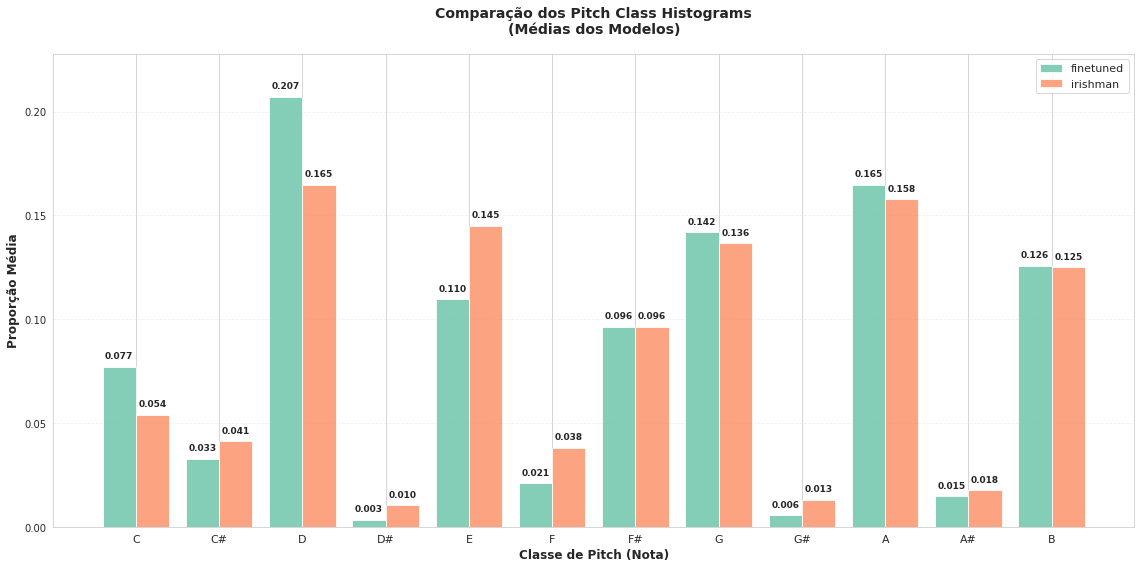

In [7]:
# Criar gr√°fico de barras agrupadas
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(note_labels))
width = 0.4

# Calcular m√©dias para cada modelo
mean_hist_1 = np.mean(pitch_hist_1, axis=0)
mean_hist_2 = np.mean(pitch_hist_2, axis=0)

# Barras
bars1 = ax.bar(x - width/2, mean_hist_1, width, 
               label=MODEL_1, color='#66c2a5', alpha=0.8)
bars2 = ax.bar(x + width/2, mean_hist_2, width,
               label=MODEL_2, color='#fc8d62', alpha=0.8)

# Customiza√ß√£o
ax.set_xlabel('Classe de Pitch (Nota)', fontsize=12, weight='bold')
ax.set_ylabel('Propor√ß√£o M√©dia', fontsize=12, weight='bold')
ax.set_title('Compara√ß√£o dos Pitch Class Histograms\n(M√©dias dos Modelos)', 
             fontsize=14, weight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(note_labels, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar valores nas barras
for i, (bar1, bar2, val1, val2) in enumerate(zip(bars1, bars2, mean_hist_1, mean_hist_2)):
    if val1 > 0.001:  # Mostrar valores acima de 0.1%
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.003,
                '{:.3f}'.format(val1), ha='center', va='bottom', fontsize=9, weight='bold')
    if val2 > 0.001:  # Mostrar valores acima de 0.1%
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.003,
                '{:.3f}'.format(val2), ha='center', va='bottom', fontsize=9, weight='bold')

# Ajustar limite superior do eixo Y para acomodar os valores nas barras
max_height = max(np.max(mean_hist_1), np.max(mean_hist_2))
ax.set_ylim(0, max_height * 1.10)  # 10% de margem superior

plt.tight_layout()
plt.show()

#### 2. Visualiza√ß√£o Consolidada - Radar Chart Comparativo

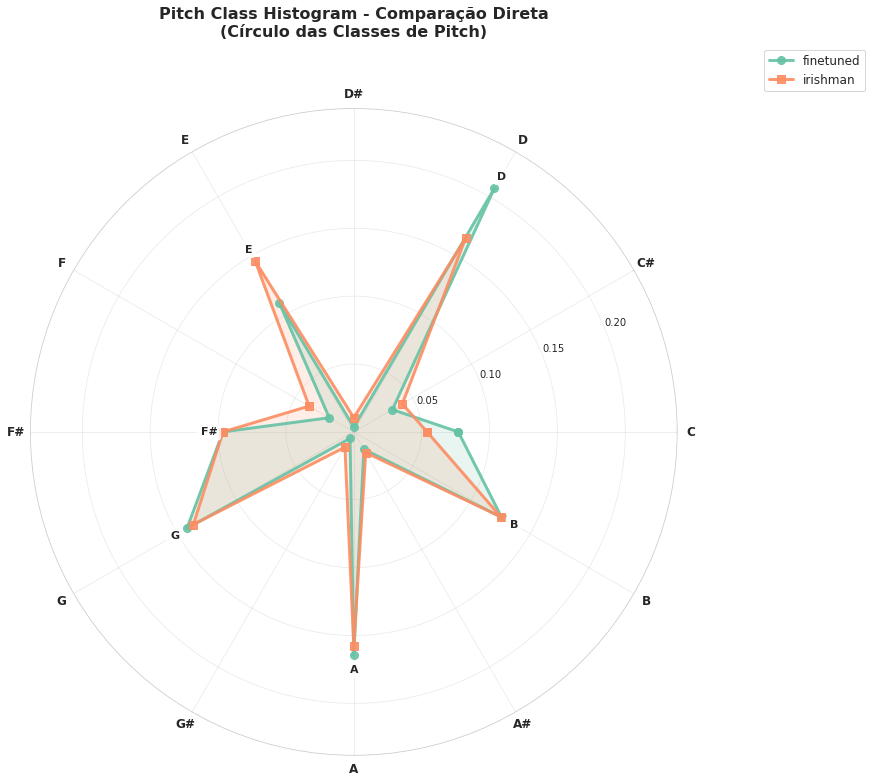

In [8]:
# Gr√°fico radar/spider final - compara√ß√£o direta dos dois modelos
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# √Çngulos para as 12 notas (melhor organiza√ß√£o visual)
angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)

# Fechar o pol√≠gono (repetir primeiro valor no final)
angles_closed = np.concatenate([angles, [angles[0]]])
values_1_closed = np.concatenate([mean_hist_1, [mean_hist_1[0]]])
values_2_closed = np.concatenate([mean_hist_2, [mean_hist_2[0]]])

# Plot dos dois modelos
ax.plot(angles_closed, values_1_closed, 'o-', linewidth=3, 
        label=MODEL_1, color='#66c2a5', markersize=8, alpha=0.9)
ax.fill(angles_closed, values_1_closed, alpha=0.15, color='#66c2a5')

ax.plot(angles_closed, values_2_closed, 's-', linewidth=3, 
        label=MODEL_2, color='#fc8d62', markersize=8, alpha=0.9)
ax.fill(angles_closed, values_2_closed, alpha=0.15, color='#fc8d62')

# Customiza√ß√£o
ax.set_xticks(angles)
ax.set_xticklabels(note_labels, fontsize=12, weight='bold')
ax.set_title('Pitch Class Histogram - Compara√ß√£o Direta\n(C√≠rculo das Classes de Pitch)', 
             fontsize=16, weight='bold', pad=40)
ax.grid(True, alpha=0.4)
ax.set_ylim(0, max(np.max(mean_hist_1), np.max(mean_hist_2)) * 1.15)

# Legenda
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

# Adicionar valores nos pontos principais (apenas os maiores valores)
max_indices = np.argsort(mean_hist_1 + mean_hist_2)[-6:]  # top 6
for i in max_indices:
    angle = angles[i]
    val1, val2 = mean_hist_1[i], mean_hist_2[i]
    max_val = max(val1, val2)
    
    # Texto do lado externo do c√≠rculo
    radius_text = max_val + max(np.max(mean_hist_1), np.max(mean_hist_2)) * 0.05
    ax.text(angle, radius_text, '{}'.format(note_labels[i]), 
           ha='center', va='center', fontsize=11, weight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Feature: `pitch_class_transition_matrix`

## Vis√£o Geral

A fun√ß√£o `pitch_class_transition_matrix` √© uma ferramenta de an√°lise musical que calcula uma **matriz de transi√ß√£o de classes de altura** (pitch class transition matrix). Esta fun√ß√£o est√° localizada na linha 243 do arquivo `core.py` e √© fundamental para an√°lise de padr√µes harm√¥nicos e mel√≥dicos em dados MIDI.

## Defini√ß√£o

Uma matriz de transi√ß√£o de classes de altura √© uma representa√ß√£o bidimensional semelhante a um histograma que conta as transi√ß√µes de altura para cada par ordenado de notas. As classes de altura representam as 12 notas musicais crom√°ticas (C, C#, D, D#, E, F, F#, G, G#, A, A#, B), independentemente da oitava em que s√£o tocadas.

## Assinatura da Fun√ß√£o

```python
def pitch_class_transition_matrix(self, feature, normalize=0):
```

### Par√¢metros

- **`feature`**: Dicion√°rio contendo dados musicais com um objeto `pretty_midi`
- **`normalize`**: Par√¢metro de normaliza√ß√£o (padr√£o: 0)
  - `0`: Retorna a matriz sem normaliza√ß√£o (contagens absolutas)
  - `1`: Normaliza por linha (cada linha soma 1)
  - `2`: Normaliza pela soma total da matriz (toda matriz soma 1)

### Retorno

- **`transition_matrix`**: Matriz numpy de forma [12, 12] representando as transi√ß√µes entre classes de altura

## Como Funciona

1. **Extra√ß√£o dos dados**: A fun√ß√£o obt√©m o objeto `pretty_midi` dos dados de entrada
2. **C√°lculo da matriz**: Chama o m√©todo `get_pitch_class_transition_matrix()` que:
   - Analisa sequencialmente as notas na m√∫sica
   - Conta quantas vezes cada classe de altura √© seguida por outra
   - Constr√≥i uma matriz 12√ó12 onde `matriz[i][j]` = n√∫mero de vezes que a nota `i` foi seguida pela nota `j`
3. **Normaliza√ß√£o**: Aplica o tipo de normaliza√ß√£o especificado

## Tipos de Normaliza√ß√£o

### Sem Normaliza√ß√£o (normalize=0)
```python
return transition_matrix
```
Retorna as contagens brutas das transi√ß√µes.

### Normaliza√ß√£o por Linha (normalize=1)
```python
sums = np.sum(transition_matrix, axis=1)
sums[sums == 0] = 1
return transition_matrix / sums.reshape(-1, 1)
```
Cada linha da matriz soma 1, representando probabilidades condicionais de transi√ß√£o a partir de cada nota.

### Normaliza√ß√£o Global (normalize=2)
```python
return transition_matrix / sum(sum(transition_matrix))
```
Toda a matriz soma 1, representando a distribui√ß√£o de probabilidade conjunta das transi√ß√µes.

## Aplica√ß√µes Musicais

### 1. Detec√ß√£o de Tonalidade
Diferentes tonalidades produzem padr√µes caracter√≠sticos de transi√ß√£o. Por exemplo:
- **D√≥ Maior**: Mais transi√ß√µes entre C-D, D-E, E-F, F-G, G-A, A-B, B-C
- **D√≥ menor**: Padr√µes diferentes envolvendo E‚ô≠, A‚ô≠, B‚ô≠

### 2. Reconhecimento de Acordes
Progress√µes harm√¥nicas comuns criam assinaturas espec√≠ficas:
- **I-V-vi-IV**: Produz padr√µes de transi√ß√£o caracter√≠sticos
- **ii-V-I**: Gera sequ√™ncias previs√≠veis na matriz

### 3. An√°lise de G√™nero Musical
Diferentes estilos musicais apresentam padr√µes distintos:
- **Jazz**: Transi√ß√µes crom√°ticas mais frequentes
- **Folk/Pop**: Transi√ß√µes diat√¥nicas predominantes
- **M√∫sica atonal**: Distribui√ß√£o mais uniforme

## Exemplo Pr√°tico

Para uma melodia simples em D√≥ Maior: `C-D-E-F-G-A-B-C`

A matriz de transi√ß√£o teria valores n√£o-zero nas posi√ß√µes:
- `[0,2]`: C‚ÜíD (1 transi√ß√£o)
- `[2,4]`: D‚ÜíE (1 transi√ß√£o)  
- `[4,5]`: E‚ÜíF (1 transi√ß√£o)
- `[5,7]`: F‚ÜíG (1 transi√ß√£o)
- `[7,9]`: G‚ÜíA (1 transi√ß√£o)
- `[9,11]`: A‚ÜíB (1 transi√ß√£o)
- `[11,0]`: B‚ÜíC (1 transi√ß√£o)

## Interpreta√ß√£o dos Resultados

### Matriz Normalizada por Linha
- Cada elemento `[i,j]` representa: "Dado que acabei de tocar a nota `i`, qual a probabilidade de tocar a nota `j` em seguida?"
- √ötil para an√°lise de padr√µes mel√≥dicos e harm√¥nicos

### Matriz Normalizada Globalmente  
- Cada elemento representa a frequ√™ncia relativa de cada tipo de transi√ß√£o no contexto da pe√ßa inteira
- √ötil para compara√ß√£o entre diferentes pe√ßas musicais

## Considera√ß√µes T√©cnicas

- A matriz sempre ter√° dimens√µes 12√ó12, correspondendo √†s 12 classes de altura crom√°ticas
- Valores na diagonal principal representam repeti√ß√µes da mesma nota
- A soma das linhas na normaliza√ß√£o por linha sempre ser√° 1 (exceto para linhas totalmente vazias)
- A fun√ß√£o trata casos especiais onde n√£o h√° transi√ß√µes a partir de certas notas

## Limita√ß√µes

1. **Perda de informa√ß√£o temporal**: A matriz n√£o preserva informa√ß√£o sobre timing ou dura√ß√£o
2. **Redu√ß√£o de oitavas**: Todas as notas s√£o reduzidas √†s suas classes de altura (C1, C4, C7 ‚Üí C)
3. **Contexto harm√¥nico**: N√£o distingue entre diferentes contextos harm√¥nicos da mesma transi√ß√£o

Esta ferramenta √© essencial para an√°lise computacional de m√∫sica, fornecendo uma representa√ß√£o compacta e matematicamente trat√°vel dos padr√µes de altura em composi√ß√µes musicais.

In [9]:
# Explorar os dados da pitch_class_transition_matrix
transition_1 = set1_loaded_results['pitch_class_transition_matrix']
transition_2 = set2_loaded_results['pitch_class_transition_matrix']

print("Shape do {}: {}".format(MODEL_1, transition_1.shape))
print("Shape do {}: {}".format(MODEL_2, transition_2.shape))
print("\nPrimeiro exemplo {} (original):".format(MODEL_1))
print(transition_1[0])
print("Soma da primeira matriz {}: {:.4f}".format(MODEL_1, np.sum(transition_1[0])))

print("\nPrimeiro exemplo {} (original):".format(MODEL_2))
print(transition_2[0])
print("Soma da primeira matriz {}: {:.4f}".format(MODEL_2, np.sum(transition_2[0])))

# Verificar se h√° valores significativos
print("\nEstat√≠sticas b√°sicas:")
print("{} - valores n√£o-zero: {:.1f}%, m√°ximo: {:.4f}".format(
    MODEL_1, np.mean(transition_1 > 0) * 100, np.max(transition_1)))
print("{} - valores n√£o-zero: {:.1f}%, m√°ximo: {:.4f}".format(
    MODEL_2, np.mean(transition_2 > 0) * 100, np.max(transition_2)))

Shape do finetuned: (93, 12, 12)
Shape do irishman: (93, 12, 12)

Primeiro exemplo finetuned (original):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 0. 0. 1. 0. 0. 3. 0. 8.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 2. 0. 0. 6. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 3. 0. 5.]]
Soma da primeira matriz finetuned: 63.0000

Primeiro exemplo irishman (original):
[[ 0.  0.  0.  0. 10.  0.  0.  0.  0. 14.  0. 12.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  6.  0. 10.  0.  0.  4.  0.  0.  0. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [10.  0. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  0.  0. 28.  0. 

In [10]:
# Preparar dados para visualiza√ß√£o
from matplotlib.gridspec import GridSpec

# Calcular matrizes m√©dias normalizadas por linha (probabilidades de transi√ß√£o)
def normalize_transition_matrix(matrix):
    """Normaliza matriz de transi√ß√£o por linha (probabilidades condicionais)"""
    normalized = matrix.copy()
    row_sums = np.sum(matrix, axis=2, keepdims=True)
    row_sums[row_sums == 0] = 1  # Evitar divis√£o por zero
    normalized = matrix / row_sums
    return normalized

# Normalizar todas as matrizes
transition_1_norm = normalize_transition_matrix(transition_1)
transition_2_norm = normalize_transition_matrix(transition_2)

# Calcular m√©dias
mean_transition_1 = np.mean(transition_1_norm, axis=0)
mean_transition_2 = np.mean(transition_2_norm, axis=0)

# Calcular diferen√ßa (Model1 - Model2)
diff_matrix = mean_transition_1 - mean_transition_2

# Labels das notas
note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Prepara√ß√£o conclu√≠da!")
print("Matriz m√©dia {} - valores n√£o-zero: {:.1f}%".format(
    MODEL_1, np.mean(mean_transition_1 > 0.001) * 100))
print("Matriz m√©dia {} - valores n√£o-zero: {:.1f}%".format(
    MODEL_2, np.mean(mean_transition_2 > 0.001) * 100))

Prepara√ß√£o conclu√≠da!
Matriz m√©dia finetuned - valores n√£o-zero: 78.5%
Matriz m√©dia irishman - valores n√£o-zero: 88.2%


#### 1. Heatmaps Comparativos - Matrizes de Transi√ß√£o M√©dias

Os heatmaps mostram as **probabilidades de transi√ß√£o condicionais**: dado que tocamos a nota da linha, qual a probabilidade de tocar a nota da coluna em seguida.

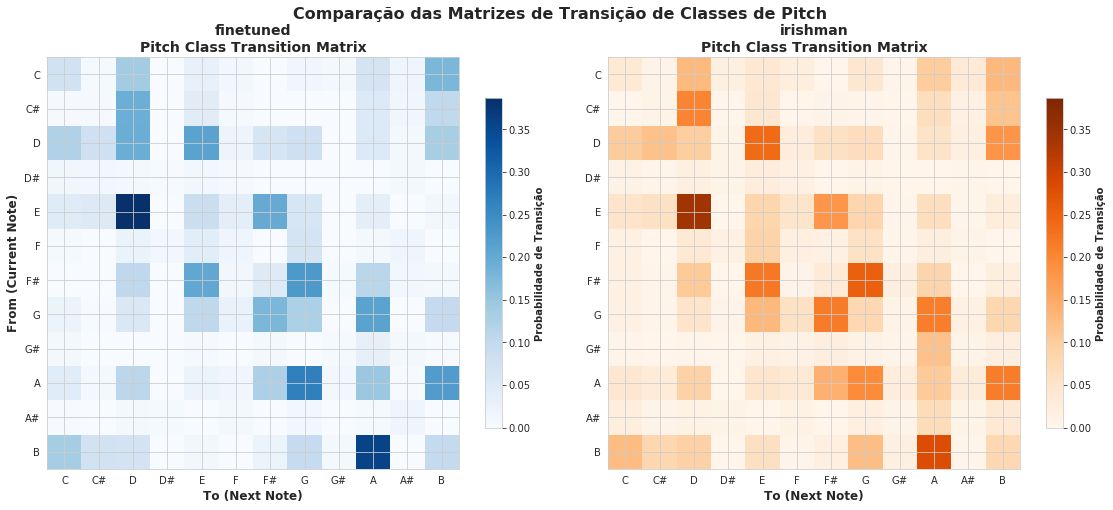

In [11]:
# 1. Heatmaps comparativos das matrizes de transi√ß√£o
fig = plt.figure(figsize=(16, 7))  # Aumentei a altura da figura
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# Definir escala comum para compara√ß√£o
vmax = max(np.max(mean_transition_1), np.max(mean_transition_2))
vmin = 0

# Subplot 1: Model 1
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(mean_transition_1, cmap='Blues', aspect='equal', 
                 vmin=vmin, vmax=vmax, interpolation='nearest')
ax1.set_title('{}\nPitch Class Transition Matrix'.format(MODEL_1), fontsize=14, weight='bold')
ax1.set_xlabel('To (Next Note)', fontsize=12, weight='bold')
ax1.set_ylabel('From (Current Note)', fontsize=12, weight='bold')
ax1.set_xticks(range(12))
ax1.set_yticks(range(12))
ax1.set_xticklabels(note_labels, fontsize=10)
ax1.set_yticklabels(note_labels, fontsize=10)

# Subplot 2: Model 2
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(mean_transition_2, cmap='Oranges', aspect='equal', 
                 vmin=vmin, vmax=vmax, interpolation='nearest')
ax2.set_title('{}\nPitch Class Transition Matrix'.format(MODEL_2), fontsize=14, weight='bold')
ax2.set_xlabel('To (Next Note)', fontsize=12, weight='bold')
ax2.set_ylabel('')
ax2.set_xticks(range(12))
ax2.set_yticks(range(12))
ax2.set_xticklabels(note_labels, fontsize=10)
ax2.set_yticklabels(note_labels, fontsize=10)

# Colorbars
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Probabilidade de Transi√ß√£o', fontsize=10, weight='bold')
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Probabilidade de Transi√ß√£o', fontsize=10, weight='bold')

plt.suptitle('Compara√ß√£o das Matrizes de Transi√ß√£o de Classes de Pitch', 
             fontsize=16, weight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

#### 2. Visualiza√ß√£o em Rede das Transi√ß√µes Principais

Esta visualiza√ß√£o mostra as transi√ß√µes como uma rede de conex√µes entre as notas, onde a espessura das setas representa a probabilidade de transi√ß√£o:

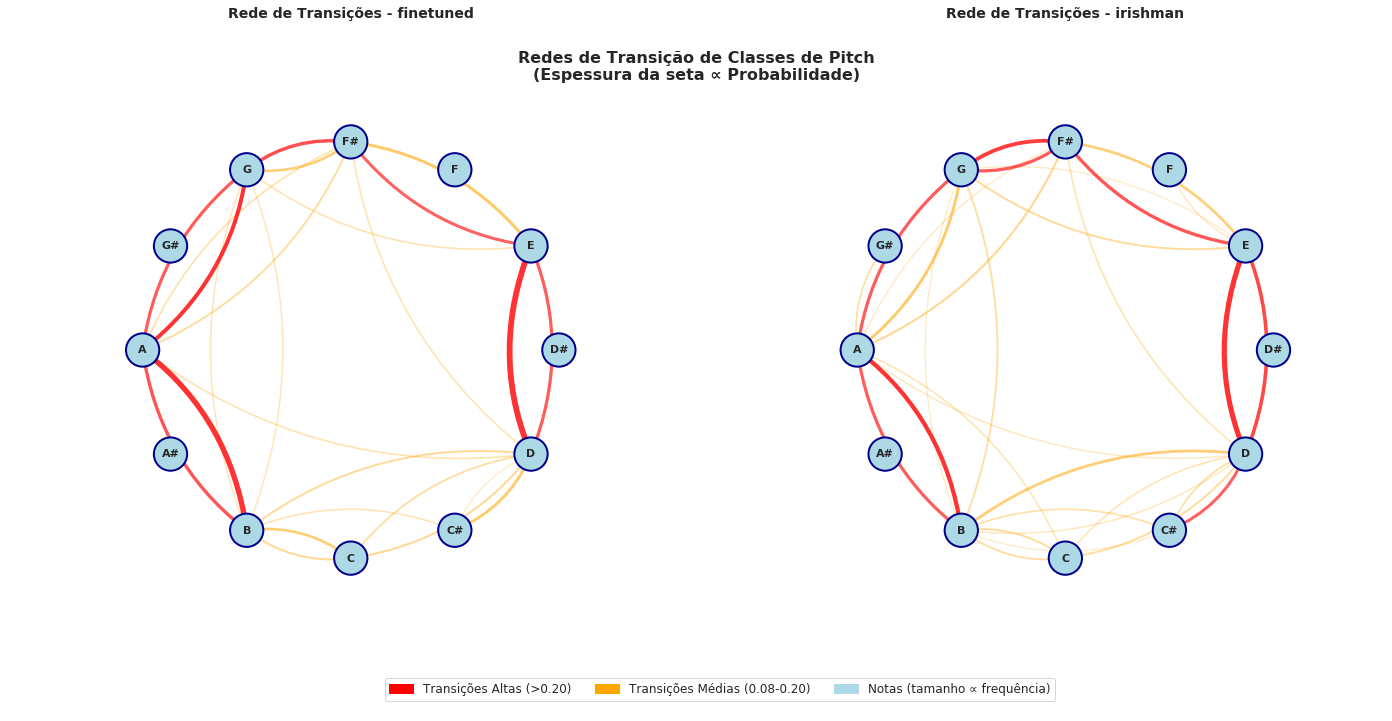

In [12]:
# 3. Visualiza√ß√£o em rede das transi√ß√µes (c√≠rculo das quintas adaptado)
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

def plot_transition_network(matrix, title, ax, threshold=0.08):
    """Plota rede de transi√ß√µes em layout circular"""
    
    # Posi√ß√µes das notas em c√≠rculo (ordem crom√°tica)
    angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
    angles = angles - np.pi/2  # Come√ßar no topo (C)
    
    radius = 1.0
    positions = {}
    for i, note in enumerate(note_labels):
        x = radius * np.cos(angles[i])
        y = radius * np.sin(angles[i])
        positions[note] = (x, y)
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    
    # Desenhar n√≥s (notas)
    for note, (x, y) in positions.items():
        # Tamanho do n√≥ baseado na frequ√™ncia total de uso
        note_idx = note_labels.index(note)
        total_from = np.sum(matrix[note_idx, :])
        total_to = np.sum(matrix[:, note_idx])
        node_size = (total_from + total_to) * 1000 + 300
        
        circle = plt.Circle((x, y), 0.08, color='lightblue', 
                          ec='darkblue', linewidth=2, zorder=3)
        ax.add_patch(circle)
        ax.text(x, y, note, ha='center', va='center', 
                fontsize=11, weight='bold', zorder=4)
    
    # Desenhar arestas (transi√ß√µes acima do threshold)
    for i in range(12):
        for j in range(12):
            if matrix[i, j] > threshold and i != j:  # N√£o mostrar auto-loops
                from_note = note_labels[i]
                to_note = note_labels[j]
                
                x1, y1 = positions[from_note]
                x2, y2 = positions[to_note]
                
                # Calcular ponto de controle para curva
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                
                # Dist√¢ncia do centro para criar curvatura
                center_dist = np.sqrt(mid_x**2 + mid_y**2)
                if center_dist > 0:
                    # Curvar para fora do c√≠rculo
                    curve_factor = 0.3
                    ctrl_x = mid_x + (mid_x/center_dist) * curve_factor
                    ctrl_y = mid_y + (mid_y/center_dist) * curve_factor
                else:
                    ctrl_x, ctrl_y = mid_x, mid_y
                
                # Espessura da linha proporcional √† probabilidade
                line_width = matrix[i, j] * 15
                alpha = min(0.8, matrix[i, j] * 3)
                
                # Desenhar seta curvada
                arrow = mpatches.FancyArrowPatch(
                    (x1, y1), (x2, y2),
                    connectionstyle="arc3,rad=0.2",
                    arrowstyle='->', 
                    mutation_scale=15,
                    linewidth=line_width,
                    color='red' if matrix[i, j] > 0.2 else 'orange',
                    alpha=alpha,
                    zorder=2
                )
                ax.add_patch(arrow)
    
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    ax.axis('off')

# Criar figura com duas redes lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plot_transition_network(mean_transition_1, 
                       'Rede de Transi√ß√µes - {}'.format(MODEL_1), 
                       ax1, threshold=0.08)

plot_transition_network(mean_transition_2, 
                       'Rede de Transi√ß√µes - {}'.format(MODEL_2), 
                       ax2, threshold=0.08)

# Legenda
legend_elements = [
    mpatches.Patch(color='red', label='Transi√ß√µes Altas (>0.20)'),
    mpatches.Patch(color='orange', label='Transi√ß√µes M√©dias (0.08-0.20)'),
    mpatches.Patch(color='lightblue', label='Notas (tamanho ‚àù frequ√™ncia)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          fontsize=12, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Redes de Transi√ß√£o de Classes de Pitch\n(Espessura da seta ‚àù Probabilidade)', 
             fontsize=16, weight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [13]:
# Sum√°rio das principais diferen√ßas entre os modelos

print("="*80)
print("SUM√ÅRIO: AN√ÅLISE DE TRANSI√á√ïES DE CLASSES DE PITCH")
print("="*80)

# 1. Calcular diferen√ßas absolutas entre as matrizes
diff_matrix = np.abs(mean_transition_1 - mean_transition_2)

# Encontrar as maiores diferen√ßas
flat_diff = diff_matrix.flatten()
sorted_indices = np.argsort(flat_diff)[::-1]

print("\n1. MAIORES DIFEREN√áAS ENTRE OS MODELOS (Top 10)")
print("-" * 60)
for i in range(10):
    idx = sorted_indices[i]
    from_note = idx // 12
    to_note = idx % 12
    diff = diff_matrix[from_note, to_note]
    prob1 = mean_transition_1[from_note, to_note]
    prob2 = mean_transition_2[from_note, to_note]
    
    print("{:>3} ‚Üí {:<3}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        note_labels[from_note], note_labels[to_note], 
        MODEL_1, prob1, MODEL_2, prob2, diff))

# 2. An√°lise das notas mais utilizadas (diagonal principal)
print("\n2. REPETI√á√ÉO DE NOTAS (Diagonal Principal)")
print("-" * 60)
diag_1 = np.diag(mean_transition_1)
diag_2 = np.diag(mean_transition_2)

for i, note in enumerate(note_labels):
    print("{:>3}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        note, MODEL_1, diag_1[i], MODEL_2, diag_2[i], 
        abs(diag_1[i] - diag_2[i])))

# 3. Estat√≠sticas gerais
entropy_1 = -np.sum(mean_transition_1 * np.log2(mean_transition_1 + 1e-10))
entropy_2 = -np.sum(mean_transition_2 * np.log2(mean_transition_2 + 1e-10))

print("\n3. ESTAT√çSTICAS GERAIS")
print("-" * 60)
print("Entropia das transi√ß√µes:")
print("  {}: {:.3f}".format(MODEL_1, entropy_1))
print("  {}: {:.3f}".format(MODEL_2, entropy_2))
print("  Diferen√ßa: {:.3f}".format(abs(entropy_1 - entropy_2)))

# 4. An√°lise de intervalos musicais
intervals = {
    'Un√≠sono': [0], 'Semitom': [1, 11], 'Tom': [2, 10], 
    'Ter√ßa menor': [3, 9], 'Ter√ßa maior': [4, 8], 'Quarta': [5, 7], 'Tr√≠tono': [6]
}

print("\n4. AN√ÅLISE POR INTERVALOS MUSICAIS")
print("-" * 60)
for interval_name, semitones in intervals.items():
    sum_1 = sum_2 = 0
    count = 0
    for i in range(12):
        for j in range(12):
            interval = (j - i) % 12
            if interval in semitones:
                sum_1 += mean_transition_1[i, j]
                sum_2 += mean_transition_2[i, j]
                count += 1
    
    avg_1 = sum_1 / count if count > 0 else 0
    avg_2 = sum_2 / count if count > 0 else 0
    print("{:>12}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        interval_name, MODEL_1, avg_1, MODEL_2, avg_2, 
        abs(avg_1 - avg_2)))

print("="*80)
print("CONCLUS√ïES:")
print("- As diferen√ßas mais significativas mostram padr√µes composicionais distintos")
print("- A an√°lise de intervalos revela prefer√™ncias harm√¥nicas diferentes")
print("- As redes de transi√ß√£o visualizam as 'assinaturas' musicais de cada modelo")
print("="*80)

SUM√ÅRIO: AN√ÅLISE DE TRANSI√á√ïES DE CLASSES DE PITCH

1. MAIORES DIFEREN√áAS ENTRE OS MODELOS (Top 10)
------------------------------------------------------------
  D ‚Üí D  : finetuned = 0.193 | irishman = 0.099 | Diff = 0.094
 G# ‚Üí A  : finetuned = 0.030 | irishman = 0.116 | Diff = 0.086
  B ‚Üí A  : finetuned = 0.356 | irishman = 0.282 | Diff = 0.074
  A ‚Üí G  : finetuned = 0.266 | irishman = 0.196 | Diff = 0.071
 A# ‚Üí A  : finetuned = 0.005 | irishman = 0.070 | Diff = 0.065
  B ‚Üí E  : finetuned = 0.010 | irishman = 0.063 | Diff = 0.053
  D ‚Üí B  : finetuned = 0.132 | irishman = 0.183 | Diff = 0.050
  G ‚Üí G  : finetuned = 0.127 | irishman = 0.077 | Diff = 0.050
  C ‚Üí B  : finetuned = 0.177 | irishman = 0.128 | Diff = 0.049
  F ‚Üí E  : finetuned = 0.042 | irishman = 0.089 | Diff = 0.047

2. REPETI√á√ÉO DE NOTAS (Diagonal Principal)
------------------------------------------------------------
  C: finetuned = 0.075 | irishman = 0.037 | Diff = 0.038
 C#: finetuned = 0.0

# Feature: `pitch_range`

## Vis√£o Geral
A fun√ß√£o `pitch_range` na linha 274 do arquivo `core.py` calcula o **alcance de pitch** (intervalo de altura das notas) de uma m√∫sica. Esta m√©trica mede a extens√£o total das notas utilizadas em uma composi√ß√£o musical.

## Defini√ß√£o
O pitch range √© calculado pela subtra√ß√£o entre a nota mais aguda (highest) e a mais grave (lowest) utilizadas na m√∫sica, expresso em semitons.

## Implementa√ß√£o

```python
def pitch_range(self, feature):
    """
    pitch_range (Pitch range):
    The pitch range is calculated by subtraction of the highest and lowest used pitch in semitones.

    Returns:
    'p_range': a scalar for each sample.
    """
    piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
    pitch_index = np.where(np.sum(piano_roll, axis=1) > 0)
    p_range = np.max(pitch_index) - np.min(pitch_index)
    return p_range
```

## Como Funciona

### 1. Extra√ß√£o do Piano Roll
```python
piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
```
- **Objetivo**: Obt√©m uma representa√ß√£o matricial da m√∫sica (piano roll)
- **Par√¢metros**: 
  - `fs=100`: Frequ√™ncia de amostragem de 100 Hz
  - `instruments[0]`: Utiliza o primeiro instrumento da composi√ß√£o
- **Resultado**: Matriz onde:
  - Cada linha representa uma nota MIDI (0-127)
  - Cada coluna representa um momento no tempo
  - Valores indicam a velocidade/intensidade da nota naquele momento

### 2. Identifica√ß√£o das Notas Utilizadas
```python
pitch_index = np.where(np.sum(piano_roll, axis=1) > 0)
```
- **Objetivo**: Identifica quais notas foram efetivamente tocadas na m√∫sica
- **Processo**:
  - `np.sum(piano_roll, axis=1)`: Soma cada linha do piano roll (todas as ocorr√™ncias de cada nota)
  - `> 0`: Verifica se a nota foi tocada pelo menos uma vez
  - `np.where(...)`: Retorna os √≠ndices das notas que foram utilizadas

### 3. C√°lculo do Alcance
```python
p_range = np.max(pitch_index) - np.min(pitch_index)
```
- **Objetivo**: Calcula a diferen√ßa entre a nota mais alta e mais baixa
- **Processo**:
  - `np.max(pitch_index)`: Encontra o √≠ndice MIDI da nota mais aguda
  - `np.min(pitch_index)`: Encontra o √≠ndice MIDI da nota mais grave
  - Subtra√ß√£o: Diferen√ßa em semitons entre ambas

## Retorno
A fun√ß√£o retorna um valor escalar (`p_range`) que representa:
- **Unidade**: Semitons
- **Significado**: Extens√£o total de pitch utilizada na composi√ß√£o
- **Tipo**: N√∫mero inteiro ou float

## Exemplos Pr√°ticos

### Exemplo 1: M√∫sica Simples
- **Notas utilizadas**: C3 (MIDI 48) ao C4 (MIDI 60)
- **Pitch Range**: 60 - 48 = 12 semitons (1 oitava)

### Exemplo 2: M√∫sica Complexa
- **Notas utilizadas**: A1 (MIDI 33) ao C7 (MIDI 96)
- **Pitch Range**: 96 - 33 = 63 semitons (aproximadamente 5 oitavas)

### Exemplo 3: Melodia Limitada
- **Notas utilizadas**: F4 (MIDI 65) ao A4 (MIDI 69)
- **Pitch Range**: 69 - 65 = 4 semitons (ter√ßa maior)

## Aplica√ß√µes

### An√°lise Musical
- **Complexidade Mel√≥dica**: Valores maiores indicam maior diversidade de alturas
- **Extens√£o Vocal/Instrumental**: √ötil para determinar a adequa√ß√£o a diferentes performers
- **Caracteriza√ß√£o de G√™neros**: Diferentes estilos musicais tendem a ter ranges caracter√≠sticos

### Compara√ß√£o de Composi√ß√µes
- Permite comparar objetivamente a extens√£o mel√≥dica entre diferentes m√∫sicas
- √ötil em estudos de an√°lise musical computacional
- Pode ser usado como feature em sistemas de machine learning

### Classifica√ß√£o Autom√°tica
- Feature importante para sistemas de classifica√ß√£o de g√™nero musical
- Auxilia na an√°lise de complexidade composicional
- √ötil para recomenda√ß√£o musical baseada em caracter√≠sticas mel√≥dicas

## Limita√ß√µes

1. **Apenas Primeiro Instrumento**: A fun√ß√£o considera apenas `instruments[0]`
2. **N√£o Considera Dura√ß√£o**: Notas muito breves t√™m o mesmo peso que notas longas
3. **Sens√≠vel a Outliers**: Uma √∫nica nota muito grave ou aguda pode distorcer o resultado

## Refer√™ncias
- Sistema MIDI: Notas numeradas de 0 (C-1) a 127 (G9)
- Pretty MIDI Library: Biblioteca para manipula√ß√£o de arquivos MIDI em Python
- Piano Roll: Representa√ß√£o visual comum em software de produ√ß√£o musical

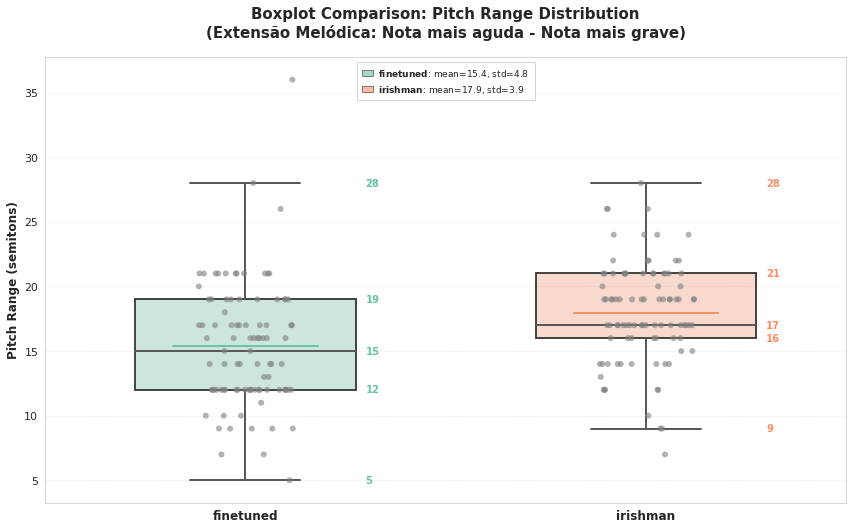

In [14]:
# Dados para pitch_range
data1_range = set1_loaded_results['pitch_range'].flatten()
data2_range = set2_loaded_results['pitch_range'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style('whitegrid')

# Cores e r√≥tulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df_range = pd.DataFrame({
    'value': np.concatenate([data1_range, data2_range]),
    'model': np.array([labels[0]] * len(data1_range) + [labels[1]] * len(data2_range))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df_range, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df_range[df_range['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da m√©dia com a cor do box (acima dos pontos)
means_range = df_range.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means_range[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats_range = df_range.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df_range.loc[df_range['model'] == lbl, 'value'].values
    q1 = float(qstats_range.loc[lbl, 0.25])
    med = float(qstats_range.loc[lbl, 0.50])
    q3 = float(qstats_range.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme defini√ß√£o do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anota√ß√µes num√©ricas √† direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda centralizada no topo
stds_range = df_range.groupby('model')['value'].std()
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats_range = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means_range[labels[0]]), float(stds_range[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means_range[labels[1]]), float(stds_range[labels[1]]))
]
handles_range = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
                 Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles_range, label_stats_range, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X sim√©tricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# R√≥tulos
ax.set_xlabel('')
ax.set_ylabel('Pitch Range (semitons)', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Pitch Range Distribution\n(Extens√£o Mel√≥dica: Nota mais aguda - Nota mais grave)', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

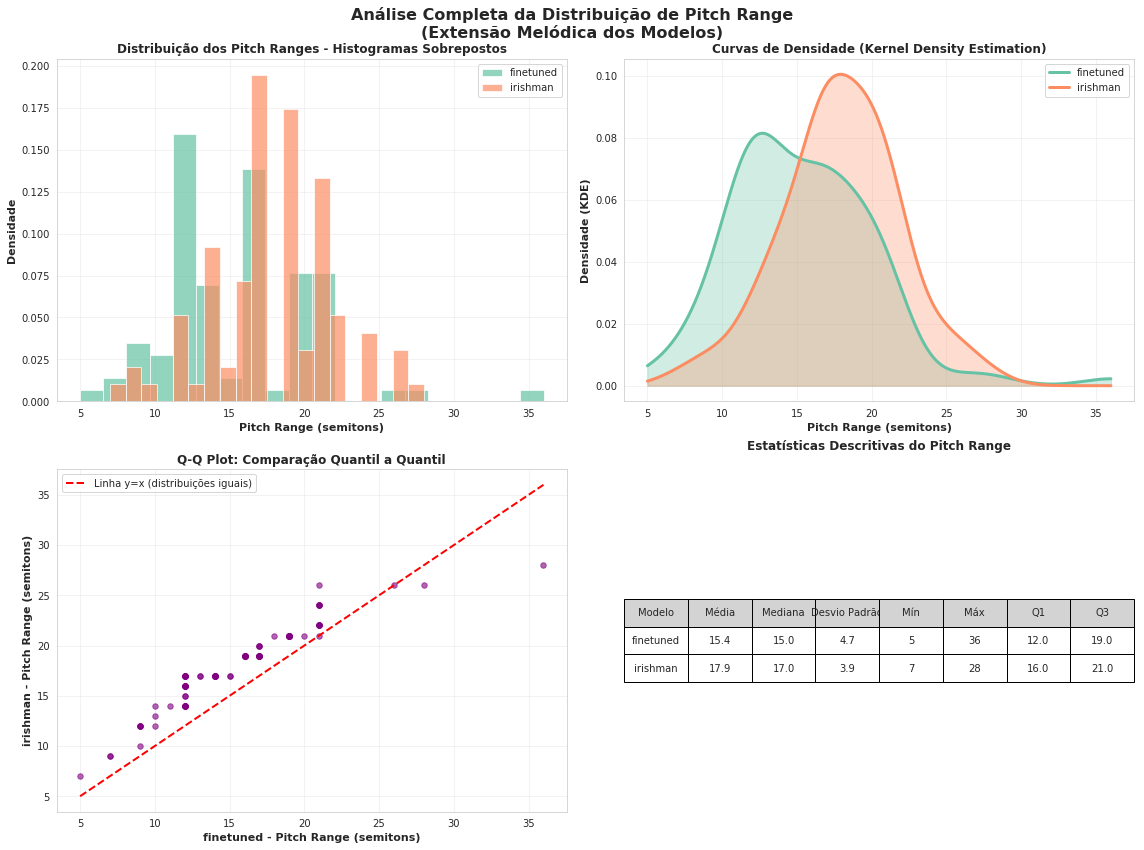

In [15]:
# Visualiza√ß√£o complementar: Histogramas e KDE sobrepostos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogramas comparativos
ax1.hist(data1_range, bins=20, alpha=0.7, color=colors[0], label=MODEL_1, density=True)
ax1.hist(data2_range, bins=20, alpha=0.7, color=colors[1], label=MODEL_2, density=True)
ax1.set_xlabel('Pitch Range (semitons)', fontsize=11, weight='bold')
ax1.set_ylabel('Densidade', fontsize=11, weight='bold')
ax1.set_title('Distribui√ß√£o dos Pitch Ranges - Histogramas Sobrepostos', fontsize=12, weight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Curvas de densidade (KDE)
from scipy.stats import gaussian_kde
x_range = np.linspace(min(np.min(data1_range), np.min(data2_range)), 
                     max(np.max(data1_range), np.max(data2_range)), 1000)

kde1 = gaussian_kde(data1_range)
kde2 = gaussian_kde(data2_range)

ax2.plot(x_range, kde1(x_range), color=colors[0], linewidth=3, label=MODEL_1)
ax2.fill_between(x_range, kde1(x_range), alpha=0.3, color=colors[0])
ax2.plot(x_range, kde2(x_range), color=colors[1], linewidth=3, label=MODEL_2)
ax2.fill_between(x_range, kde2(x_range), alpha=0.3, color=colors[1])
ax2.set_xlabel('Pitch Range (semitons)', fontsize=11, weight='bold')
ax2.set_ylabel('Densidade (KDE)', fontsize=11, weight='bold')
ax2.set_title('Curvas de Densidade (Kernel Density Estimation)', fontsize=12, weight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Q-Q Plot para compara√ß√£o direta das distribui√ß√µes
from scipy import stats
n_samples = min(len(data1_range), len(data2_range))
sorted_data1 = np.sort(data1_range)[:n_samples]
sorted_data2 = np.sort(data2_range)[:n_samples]

ax3.scatter(sorted_data1, sorted_data2, alpha=0.6, s=30, color='purple')
min_val = min(np.min(sorted_data1), np.min(sorted_data2))
max_val = max(np.max(sorted_data1), np.max(sorted_data2))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Linha y=x (distribui√ß√µes iguais)')
ax3.set_xlabel(MODEL_1 + ' - Pitch Range (semitons)', fontsize=11, weight='bold')
ax3.set_ylabel(MODEL_2 + ' - Pitch Range (semitons)', fontsize=11, weight='bold')
ax3.set_title('Q-Q Plot: Compara√ß√£o Quantil a Quantil', fontsize=12, weight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Estat√≠sticas descritivas em formato tabela
stats_data = []
for model, data in [(MODEL_1, data1_range), (MODEL_2, data2_range)]:
    stats_data.append([
        model,
        '{:.1f}'.format(np.mean(data)),
        '{:.1f}'.format(np.median(data)),
        '{:.1f}'.format(np.std(data)),
        '{:.0f}'.format(np.min(data)),
        '{:.0f}'.format(np.max(data)),
        '{:.1f}'.format(np.percentile(data, 25)),
        '{:.1f}'.format(np.percentile(data, 75))
    ])

# Tabela
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=stats_data,
                  colLabels=['Modelo', 'M√©dia', 'Mediana', 'Desvio Padr√£o', 'M√≠n', 'M√°x', 'Q1', 'Q3'],
                  cellLoc='center',
                  loc='center',
                  colColours=['lightgray']*8)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax4.set_title('Estat√≠sticas Descritivas do Pitch Range', fontsize=12, weight='bold', pad=20)

plt.suptitle('An√°lise Completa da Distribui√ß√£o de Pitch Range\n(Extens√£o Mel√≥dica dos Modelos)', 
             fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [16]:
# An√°lise interpretativa do Pitch Range
print("="*80)
print("AN√ÅLISE INTERPRETATIVA: PITCH RANGE (EXTENS√ÉO MEL√ìDICA)")
print("="*80)

# Estat√≠sticas b√°sicas
mean_1, mean_2 = np.mean(data1_range), np.mean(data2_range)
std_1, std_2 = np.std(data1_range), np.std(data2_range)
median_1, median_2 = np.median(data1_range), np.median(data2_range)

print("\nüìä ESTAT√çSTICAS DESCRITIVAS")
print("‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê")
print("‚îÇ M√©trica         ‚îÇ {:<12} ‚îÇ {:<12} ‚îÇ".format(MODEL_1, MODEL_2))
print("‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§")
print("‚îÇ M√©dia           ‚îÇ {:>12.1f} ‚îÇ {:>12.1f} ‚îÇ".format(mean_1, mean_2))
print("‚îÇ Mediana         ‚îÇ {:>12.1f} ‚îÇ {:>12.1f} ‚îÇ".format(median_1, median_2))
print("‚îÇ Desvio Padr√£o   ‚îÇ {:>12.1f} ‚îÇ {:>12.1f} ‚îÇ".format(std_1, std_2))
print("‚îÇ M√≠nimo          ‚îÇ {:>12.0f} ‚îÇ {:>12.0f} ‚îÇ".format(np.min(data1_range), np.min(data2_range)))
print("‚îÇ M√°ximo          ‚îÇ {:>12.0f} ‚îÇ {:>12.0f} ‚îÇ".format(np.max(data1_range), np.max(data2_range)))
print("‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò")

# Interpreta√ß√£o em termos musicais
print("\nüéµ INTERPRETA√á√ÉO MUSICAL:")
print("   ‚Ä¢ M√©dia de {:.1f} semitons = {:.1f} oitavas ({})".format(mean_1, mean_1/12, MODEL_1))
print("   ‚Ä¢ M√©dia de {:.1f} semitons = {:.1f} oitavas ({})".format(mean_2, mean_2/12, MODEL_2))

# Teste estat√≠stico
from scipy import stats
t_stat, p_value = stats.ttest_ind(data1_range, data2_range)
effect_size = (mean_1 - mean_2) / np.sqrt(((len(data1_range)-1)*std_1**2 + (len(data2_range)-1)*std_2**2) / (len(data1_range)+len(data2_range)-2))

print("\nüìà TESTE ESTAT√çSTICO (T-test independente):")
print("   ‚Ä¢ Estat√≠stica t: {:.3f}".format(t_stat))
print("   ‚Ä¢ P-valor: {:.6f}".format(p_value))
print("   ‚Ä¢ Tamanho do efeito (Cohen's d): {:.3f}".format(effect_size))

if p_value < 0.001:
    significance = "altamente significativa (p < 0.001)"
elif p_value < 0.01:
    significance = "muito significativa (p < 0.01)"
elif p_value < 0.05:
    significance = "significativa (p < 0.05)"
else:
    significance = "n√£o significativa (p ‚â• 0.05)"

print("   ‚Ä¢ Interpreta√ß√£o: Diferen√ßa {}".format(significance))

# Interpreta√ß√£o do tamanho do efeito
if abs(effect_size) < 0.2:
    effect_interpretation = "pequeno"
elif abs(effect_size) < 0.5:
    effect_interpretation = "m√©dio"
elif abs(effect_size) < 0.8:
    effect_interpretation = "grande"
else:
    effect_interpretation = "muito grande"

print("   ‚Ä¢ Tamanho do efeito: {}".format(effect_interpretation))

# Categoriza√ß√£o dos ranges
def categorize_range(value):
    if value < 12:
        return "Limitado (< 1 oitava)"
    elif value < 24:
        return "Moderado (1-2 oitavas)"
    elif value < 36:
        return "Amplo (2-3 oitavas)"
    elif value < 48:
        return "Muito Amplo (3-4 oitavas)"
    else:
        return "Extremamente Amplo (> 4 oitavas)"

print("\nüéØ CATEGORIZA√á√ÉO DAS EXTENS√ïES:")
categories_1 = [categorize_range(x) for x in data1_range]
categories_2 = [categorize_range(x) for x in data2_range]

from collections import Counter
count_1 = Counter(categories_1)
count_2 = Counter(categories_2)

all_categories = ["Limitado (< 1 oitava)", "Moderado (1-2 oitavas)", "Amplo (2-3 oitavas)", 
                  "Muito Amplo (3-4 oitavas)", "Extremamente Amplo (> 4 oitavas)"]

for cat in all_categories:
    pct_1 = (count_1[cat] / len(data1_range)) * 100
    pct_2 = (count_2[cat] / len(data2_range)) * 100
    print("   ‚Ä¢ {:<25}: {} {:>5.1f}% | {} {:>5.1f}%".format(cat, MODEL_1, pct_1, MODEL_2, pct_2))

print("\nüí° CONCLUS√ïES:")
diff = mean_1 - mean_2
if abs(diff) < 1:
    print("   ‚Ä¢ Os modelos produzem extens√µes mel√≥dicas muito similares")
else:
    higher_model = MODEL_1 if diff > 0 else MODEL_2
    lower_model = MODEL_2 if diff > 0 else MODEL_1
    print("   ‚Ä¢ {} produz melodias com maior extens√£o mel√≥dica (+{:.1f} semitons)".format(higher_model, abs(diff)))
    print("   ‚Ä¢ {} tende a ser mais conservador na extens√£o das notas".format(lower_model))

# Variabilidade
if std_1 > std_2 * 1.2:
    print("   ‚Ä¢ {} √© mais vari√°vel na extens√£o mel√≥dica (mais diversidade)".format(MODEL_1))
elif std_2 > std_1 * 1.2:
    print("   ‚Ä¢ {} √© mais vari√°vel na extens√£o mel√≥dica (mais diversidade)".format(MODEL_2))
else:
    print("   ‚Ä¢ Ambos os modelos t√™m variabilidade similar na extens√£o mel√≥dica")

print("="*80)

AN√ÅLISE INTERPRETATIVA: PITCH RANGE (EXTENS√ÉO MEL√ìDICA)

üìä ESTAT√çSTICAS DESCRITIVAS
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ M√©trica         ‚îÇ finetuned    ‚îÇ irishman     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ M√©dia           ‚îÇ         15.4 ‚îÇ         17.9 ‚îÇ
‚îÇ Mediana         ‚îÇ         15.0 ‚îÇ         17.0 ‚îÇ
‚îÇ Desvio Padr√£o   ‚îÇ          4.7 ‚îÇ          3.9 ‚îÇ
‚îÇ M√≠nimo          ‚îÇ            5 ‚îÇ            7 ‚îÇ
‚îÇ M√°ximo          ‚îÇ           36 ‚îÇ           28 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

üéµ INTERPRETA√á√ÉO MUSICAL:
   ‚Ä¢ M√©dia de 15.4 semitons = 1.3 oitavas (finetuned)
   ‚Ä¢ M√©dia de 17.9 se

# Feature: `avg_pitch_shift`

## Localiza√ß√£o
**Arquivo:** `mgeval/core.py`  
**Linha:** 287

## Descri√ß√£o
A fun√ß√£o `avg_pitch_shift` calcula o **intervalo m√©dio de pitch** entre notas consecutivas em um arquivo MIDI, medido em semitons. Esta m√©trica √© √∫til para analisar caracter√≠sticas mel√≥dicas e o movimento entre notas em uma composi√ß√£o musical.

## Assinatura da Fun√ß√£o
```python
def avg_pitch_shift(self, feature, track_num=1):
```

## Par√¢metros
- **`feature`**: Dicion√°rio contendo dados do MIDI, incluindo `midi_pattern`
- **`track_num`**: N√∫mero da faixa MIDI a analisar (padr√£o = 1, segunda faixa)

## Valor de Retorno
- **`pitch_shift`**: Um valor escalar representando a m√©dia dos intervalos absolutos entre pitches consecutivos em semitons

## Algoritmo

### 1. Prepara√ß√£o dos Dados
```python
pattern = feature['midi_pattern']
pattern.make_ticks_abs()
resolution = pattern.resolution
total_used_note = self.total_used_note(feature, track_num=track_num)
```
- Extrai o padr√£o MIDI da feature
- Converte os ticks para valores absolutos
- Obt√©m o n√∫mero total de notas usadas na faixa

### 2. Inicializa√ß√£o
```python
d_note = np.zeros((max(total_used_note - 1, 0)))
current_note = 0
counter = 0
```
- Cria um array `d_note` para armazenar as diferen√ßas de pitch
- Inicializa vari√°veis de controle

### 3. Processamento das Notas
```python
for i in range(0, len(pattern[track_num])):
    if type(pattern[track_num][i]) == midi.events.NoteOnEvent and pattern[track_num][i].data[1] != 0:
        if counter != 0:
            d_note[counter - 1] = current_note - pattern[track_num][i].data[0]
            current_note = pattern[track_num][i].data[0]
            counter += 1
        else:
            current_note = pattern[track_num][i].data[0]
            counter += 1
```
- Percorre todos os eventos da faixa MIDI especificada
- Identifica eventos `NoteOnEvent` com velocidade diferente de zero (notas realmente tocadas)
- Para cada nota consecutiva, calcula a diferen√ßa de pitch em semitons
- Armazena essas diferen√ßas no array `d_note`

### 4. C√°lculo Final
```python
pitch_shift = np.mean(abs(d_note))
return pitch_shift
```
- Calcula a m√©dia dos valores absolutos das diferen√ßas de pitch
- Retorna esse valor como resultado

## Exemplo Pr√°tico

Considere uma sequ√™ncia de notas com os seguintes pitches:
- **Notas:** [60, 64, 67, 65] (D√≥, Mi, Sol, F√°)

**C√°lculo das diferen√ßas:**
- Note 1 ‚Üí Note 2: 64 - 60 = 4 semitons
- Note 2 ‚Üí Note 3: 67 - 64 = 3 semitons  
- Note 3 ‚Üí Note 4: 65 - 67 = -2 semitons

**Resultado:**
```
avg_pitch_shift = (|4| + |3| + |-2|) / 3 = (4 + 3 + 2) / 3 = 3.0 semitons
```

## Aplica√ß√µes

Esta m√©trica √© √∫til para:
- **An√°lise mel√≥dica**: Caracterizar o movimento mel√≥dico em uma pe√ßa
- **Classifica√ß√£o de estilos**: Diferentes estilos musicais podem ter padr√µes distintos de intervalos
- **Compara√ß√£o de composi√ß√µes**: Avaliar similaridades ou diferen√ßas entre diferentes pe√ßas musicais
- **Avalia√ß√£o de complexidade**: Intervalos maiores podem indicar maior complexidade mel√≥dica

## Considera√ß√µes T√©cnicas

- A fun√ß√£o utiliza valores absolutos das diferen√ßas, focando na magnitude dos intervalos independentemente da dire√ß√£o (ascendente ou descendente)
- Apenas eventos `NoteOnEvent` com velocidade > 0 s√£o considerados, ignorando notas "fantasma"
- O c√°lculo √© feito por faixa MIDI, permitindo an√°lise separada de diferentes instrumentos ou vozes

# An√°lise da M√©trica Average Pitch Shift

A m√©trica **Average Pitch Shift** calcula o intervalo m√©dio de pitch entre notas consecutivas em semitons. Esta m√©trica √© importante para analisar:

- **Movimento mel√≥dico**: Caracteriza como as notas se movem melodicamente
- **Complexidade harm√¥nica**: Intervalos maiores podem indicar maior complexidade
- **Estilo musical**: Diferentes estilos t√™m padr√µes distintos de intervalos
- **Suavidade mel√≥dica**: Valores menores indicam melodias mais suaves

## Interpreta√ß√£o dos Valores:
- **Valores baixos (0-2 semitons)**: Melodias suaves com movimento por graus conjuntos
- **Valores m√©dios (2-4 semitons)**: Movimento mel√≥dico equilibrado  
- **Valores altos (>4 semitons)**: Saltos mel√≥dicos maiores, maior complexidade

In [17]:
# Extrair dados da m√©trica Average Pitch Shift
avg_pitch_shift_set1 = set1_loaded_results['avg_pitch_shift'].flatten()
avg_pitch_shift_set2 = set2_loaded_results['avg_pitch_shift'].flatten()

print('Average Pitch Shift - Modelo 1 (Finetuned):')
print('  Amostras: {}'.format(len(avg_pitch_shift_set1)))
print('  M√©dia: {:.3f} semitons'.format(np.mean(avg_pitch_shift_set1)))
print('  Desvio padr√£o: {:.3f}'.format(np.std(avg_pitch_shift_set1)))
print('  Min: {:.3f} - Max: {:.3f}'.format(np.min(avg_pitch_shift_set1), np.max(avg_pitch_shift_set1)))

print('\nAverage Pitch Shift - Modelo 2 (Irishman):')
print('  Amostras: {}'.format(len(avg_pitch_shift_set2)))
print('  M√©dia: {:.3f} semitons'.format(np.mean(avg_pitch_shift_set2)))
print('  Desvio padr√£o: {:.3f}'.format(np.std(avg_pitch_shift_set2)))
print('  Min: {:.3f} - Max: {:.3f}'.format(np.min(avg_pitch_shift_set2), np.max(avg_pitch_shift_set2)))

# Remover valores NaN se existirem
avg_pitch_shift_set1_clean = avg_pitch_shift_set1[~np.isnan(avg_pitch_shift_set1)]
avg_pitch_shift_set2_clean = avg_pitch_shift_set2[~np.isnan(avg_pitch_shift_set2)]

print('\nAp√≥s limpeza de NaN:')
print('  Modelo 1: {} amostras v√°lidas'.format(len(avg_pitch_shift_set1_clean)))
print('  Modelo 2: {} amostras v√°lidas'.format(len(avg_pitch_shift_set2_clean)))

Average Pitch Shift - Modelo 1 (Finetuned):
  Amostras: 93
  M√©dia: 2.402 semitons
  Desvio padr√£o: 0.908
  Min: 0.877 - Max: 6.362

Average Pitch Shift - Modelo 2 (Irishman):
  Amostras: 93
  M√©dia: 2.760 semitons
  Desvio padr√£o: 0.607
  Min: 1.610 - Max: 4.950

Ap√≥s limpeza de NaN:
  Modelo 1: 93 amostras v√°lidas
  Modelo 2: 93 amostras v√°lidas


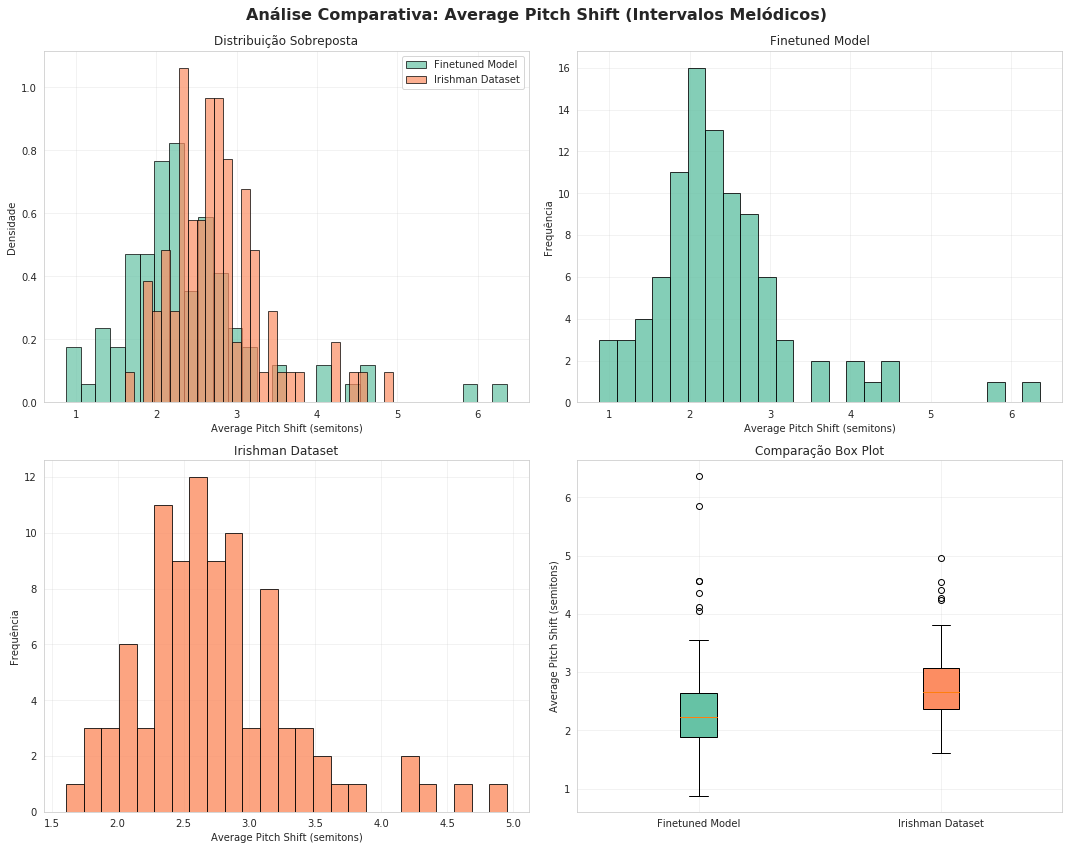


ESTAT√çSTICAS DESCRITIVAS - AVERAGE PITCH SHIFT
M√©trica                   Finetuned    Irishman     Diferen√ßa   
------------------------------------------------------------
M√©dia                     2.402        2.760        -0.358      
Mediana                   2.223        2.654        -0.431      
Desvio Padr√£o             0.908        0.607        0.301       
Q1 (25%)                  1.889        2.371        -0.482      
Q3 (75%)                  2.650        3.068        -0.417      
M√≠nimo                    0.877        1.610        -0.733      
M√°ximo                    6.362        4.950        1.411       


In [18]:
# 1. HISTOGRAMAS COMPARATIVOS
colors = ['#66c2a5', '#fc8d62']  # finetuned, irishman

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('An√°lise Comparativa: Average Pitch Shift (Intervalos Mel√≥dicos)', fontsize=16, fontweight='bold', y=0.98)

# Histograma sobreposto
axes[0, 0].hist(avg_pitch_shift_set1_clean, bins=30, alpha=0.7, label='Finetuned Model', 
                color=colors[0], density=True, edgecolor='black')
axes[0, 0].hist(avg_pitch_shift_set2_clean, bins=30, alpha=0.7, label='Irishman Dataset', 
                color=colors[1], density=True, edgecolor='black')
axes[0, 0].set_xlabel('Average Pitch Shift (semitons)')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].set_title('Distribui√ß√£o Sobreposta')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histogramas separados
axes[0, 1].hist(avg_pitch_shift_set1_clean, bins=25, alpha=0.8, color=colors[0], edgecolor='black')
axes[0, 1].set_xlabel('Average Pitch Shift (semitons)')
axes[0, 1].set_ylabel('Frequ√™ncia')
axes[0, 1].set_title('Finetuned Model')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(avg_pitch_shift_set2_clean, bins=25, alpha=0.8, color=colors[1], edgecolor='black')
axes[1, 0].set_xlabel('Average Pitch Shift (semitons)')
axes[1, 0].set_ylabel('Frequ√™ncia')
axes[1, 0].set_title('Irishman Dataset')
axes[1, 0].grid(True, alpha=0.3)

# Box plot comparativo
box_data = [avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean]
box_labels = ['Finetuned Model', 'Irishman Dataset']
box_plot = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
box_plot['boxes'][0].set_facecolor(colors[0])
box_plot['boxes'][1].set_facecolor(colors[1])
axes[1, 1].set_ylabel('Average Pitch Shift (semitons)')
axes[1, 1].set_title('Compara√ß√£o Box Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Estat√≠sticas descritivas
print("\n" + "="*60)
print("ESTAT√çSTICAS DESCRITIVAS - AVERAGE PITCH SHIFT")
print("="*60)
print("{:<25} {:<12} {:<12} {:<12}".format('M√©trica', 'Finetuned', 'Irishman', 'Diferen√ßa'))
print("-"*60)
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('M√©dia', np.mean(avg_pitch_shift_set1_clean), np.mean(avg_pitch_shift_set2_clean), np.mean(avg_pitch_shift_set1_clean) - np.mean(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Mediana', np.median(avg_pitch_shift_set1_clean), np.median(avg_pitch_shift_set2_clean), np.median(avg_pitch_shift_set1_clean) - np.median(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Desvio Padr√£o', np.std(avg_pitch_shift_set1_clean), np.std(avg_pitch_shift_set2_clean), np.std(avg_pitch_shift_set1_clean) - np.std(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Q1 (25%)', np.percentile(avg_pitch_shift_set1_clean, 25), np.percentile(avg_pitch_shift_set2_clean, 25), np.percentile(avg_pitch_shift_set1_clean, 25) - np.percentile(avg_pitch_shift_set2_clean, 25)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Q3 (75%)', np.percentile(avg_pitch_shift_set1_clean, 75), np.percentile(avg_pitch_shift_set2_clean, 75), np.percentile(avg_pitch_shift_set1_clean, 75) - np.percentile(avg_pitch_shift_set2_clean, 75)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('M√≠nimo', np.min(avg_pitch_shift_set1_clean), np.min(avg_pitch_shift_set2_clean), np.min(avg_pitch_shift_set1_clean) - np.min(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('M√°ximo', np.max(avg_pitch_shift_set1_clean), np.max(avg_pitch_shift_set2_clean), np.max(avg_pitch_shift_set1_clean) - np.max(avg_pitch_shift_set2_clean)))


TESTES ESTAT√çSTICOS - AVERAGE PITCH SHIFT
Teste de Normalidade (Shapiro-Wilk):
  Finetuned: p-valor = 0.000000 (n√£o-normal)
  Irishman:  p-valor = 0.000089 (n√£o-normal)

Teste de Mann-Whitney U (n√£o-param√©trico):
  Estat√≠stica: 2654.500
  p-valor: 0.000005 ***

Teste t de Student (param√©trico):
  Estat√≠stica t: -3.148
  p-valor: 0.001918 **

Teste de Kolmogorov-Smirnov:
  Estat√≠stica KS: 0.376
  p-valor: 0.000002 ***

Tamanho do Efeito (Cohen's d): -0.464
  Interpreta√ß√£o: Efeito m√©dio

Signific√¢ncia: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = n√£o significativo


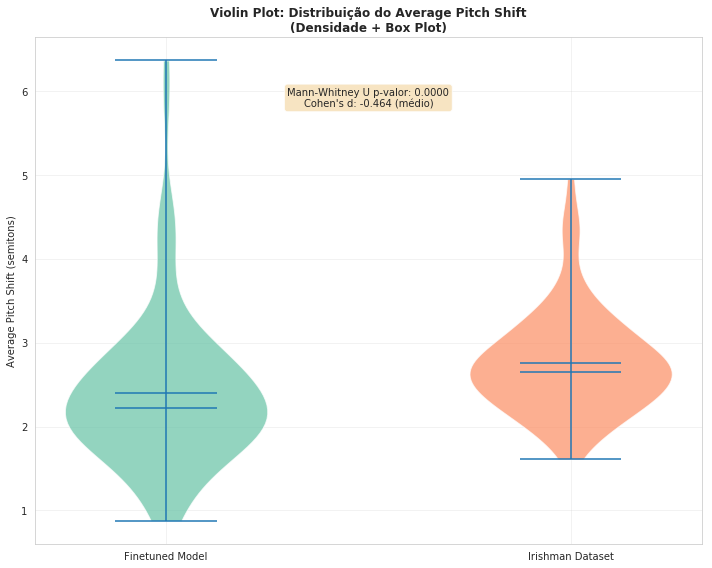

In [19]:
# 2. TESTE ESTAT√çSTICO E VIOLIN PLOT
from scipy import stats

# Teste de normalidade
_, p_normal_set1 = stats.shapiro(avg_pitch_shift_set1_clean[:min(5000, len(avg_pitch_shift_set1_clean))])
_, p_normal_set2 = stats.shapiro(avg_pitch_shift_set2_clean[:min(5000, len(avg_pitch_shift_set2_clean))])

# Teste de Mann-Whitney (n√£o-param√©trico)
statistic_mw, p_value_mw = stats.mannwhitneyu(avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean, alternative='two-sided')

# Teste t (param√©trico)
statistic_t, p_value_t = stats.ttest_ind(avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean)

# Teste de Kolmogorov-Smirnov
ks_statistic, p_value_ks = stats.ks_2samp(avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean)

# Calcular effect size (Cohen's d)
pooled_std = np.sqrt(((len(avg_pitch_shift_set1_clean) - 1) * np.var(avg_pitch_shift_set1_clean) + 
                      (len(avg_pitch_shift_set2_clean) - 1) * np.var(avg_pitch_shift_set2_clean)) / 
                     (len(avg_pitch_shift_set1_clean) + len(avg_pitch_shift_set2_clean) - 2))
cohens_d = (np.mean(avg_pitch_shift_set1_clean) - np.mean(avg_pitch_shift_set2_clean)) / pooled_std

print("\n" + "="*60)
print("TESTES ESTAT√çSTICOS - AVERAGE PITCH SHIFT")
print("="*60)
print("Teste de Normalidade (Shapiro-Wilk):")
print("  Finetuned: p-valor = {:.6f} {}".format(p_normal_set1, '(normal)' if p_normal_set1 > 0.05 else '(n√£o-normal)'))
print("  Irishman:  p-valor = {:.6f} {}".format(p_normal_set2, '(normal)' if p_normal_set2 > 0.05 else '(n√£o-normal)'))

print("\nTeste de Mann-Whitney U (n√£o-param√©trico):")
print("  Estat√≠stica: {:.3f}".format(statistic_mw))
print("  p-valor: {:.6f} {}".format(p_value_mw, '***' if p_value_mw < 0.001 else '**' if p_value_mw < 0.01 else '*' if p_value_mw < 0.05 else 'ns'))

print("\nTeste t de Student (param√©trico):")
print("  Estat√≠stica t: {:.3f}".format(statistic_t))
print("  p-valor: {:.6f} {}".format(p_value_t, '***' if p_value_t < 0.001 else '**' if p_value_t < 0.01 else '*' if p_value_t < 0.05 else 'ns'))

print("\nTeste de Kolmogorov-Smirnov:")
print("  Estat√≠stica KS: {:.3f}".format(ks_statistic))
print("  p-valor: {:.6f} {}".format(p_value_ks, '***' if p_value_ks < 0.001 else '**' if p_value_ks < 0.01 else '*' if p_value_ks < 0.05 else 'ns'))

print("\nTamanho do Efeito (Cohen's d): {:.3f}".format(cohens_d))
if abs(cohens_d) < 0.2:
    effect_size = "pequeno"
elif abs(cohens_d) < 0.5:
    effect_size = "m√©dio"
elif abs(cohens_d) < 0.8:
    effect_size = "grande"
else:
    effect_size = "muito grande"
print("  Interpreta√ß√£o: Efeito {}".format(effect_size))

print("\nSignific√¢ncia: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = n√£o significativo")

# Violin Plot
colors = ['#66c2a5', '#fc8d62']  # finetuned, irishman
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
violin_parts = ax.violinplot([avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean], 
                            positions=[1, 2], showmeans=True, showmedians=True)

# Personalizar cores
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Finetuned Model', 'Irishman Dataset'])
ax.set_ylabel('Average Pitch Shift (semitons)')
ax.set_title('Violin Plot: Distribui√ß√£o do Average Pitch Shift\n(Densidade + Box Plot)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Adicionar estat√≠sticas no gr√°fico
ax.text(1.5, max(np.max(avg_pitch_shift_set1_clean), np.max(avg_pitch_shift_set2_clean)) * 0.95,
        'Mann-Whitney U p-valor: {:.4f}\nCohen\'s d: {:.3f} ({})'.format(p_value_mw, cohens_d, effect_size),
        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

Debug das categorias:
(u'Contagens Set1:', [2, 30, 48, 6, 7])
(u'Contagens Set2:', [0, 7, 61, 20, 5])
(u'Propor\xe7\xf5es Set1:', array([ 2.15053763, 32.25806452, 51.61290323,  6.4516129 ,  7.52688172]))
(u'Propor\xe7\xf5es Set2:', array([ 0.        ,  7.52688172, 65.59139785, 21.50537634,  5.37634409]))
(u'Total Set1:', 93)
(u'Total Set2:', 93)


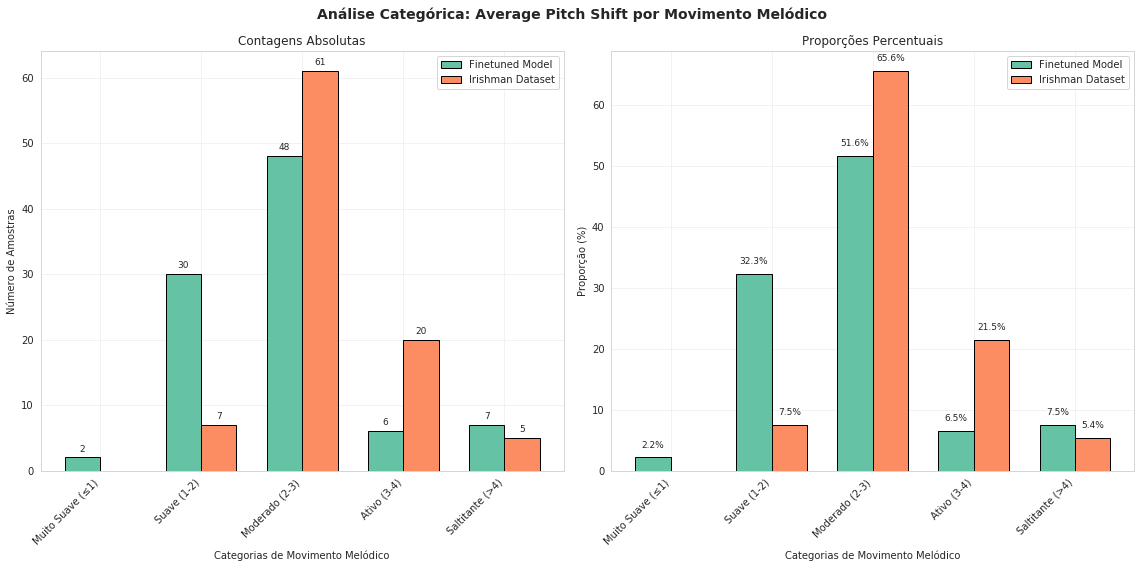


DISTRIBUI√á√ÉO POR CATEGORIAS DE MOVIMENTO MEL√ìDICO
Categoria            Finetuned       %        Irishman        %        Diferen√ßa %
--------------------------------------------------------------------------------
Muito Suave (‚â§1)     2               2.2      0               0.0          +2.2
Suave (1-2)          30              32.3     7               7.5         +24.7
Moderado (2-3)       48              51.6     61              65.6        -14.0
Ativo (3-4)          6               6.5      20              21.5        -15.1
Saltitante (>4)      7               7.5      5               5.4          +2.2

Total de amostras:
  Finetuned Model: 93 amostras
  Irishman Dataset: 93 amostras


In [20]:
# 3. AN√ÅLISE POR CATEGORIAS DE INTERVALO MEL√ìDICO
def categorize_pitch_shift(values):
    """Categoriza os valores de pitch shift em grupos mel√≥dicos"""
    categories = []
    for val in values:
        if val <= 1:
            categories.append('Muito Suave (‚â§1)')
        elif val <= 2:
            categories.append('Suave (1-2)')
        elif val <= 3:
            categories.append('Moderado (2-3)')
        elif val <= 4:
            categories.append('Ativo (3-4)')
        else:
            categories.append('Saltitante (>4)')
    return np.array(categories)

# Categorizar os dados
cat_set1 = categorize_pitch_shift(avg_pitch_shift_set1_clean)
cat_set2 = categorize_pitch_shift(avg_pitch_shift_set2_clean)

# Contar frequ√™ncias
categories_order = ['Muito Suave (‚â§1)', 'Suave (1-2)', 'Moderado (2-3)', 'Ativo (3-4)', 'Saltitante (>4)']
count_set1 = [np.sum(cat_set1 == cat) for cat in categories_order]
count_set2 = [np.sum(cat_set2 == cat) for cat in categories_order]

# Calcular propor√ß√µes
prop_set1 = np.array(count_set1) / float(len(avg_pitch_shift_set1_clean)) * 100
prop_set2 = np.array(count_set2) / float(len(avg_pitch_shift_set2_clean)) * 100

# Debug das propor√ß√µes
print("Debug das categorias:")
print("Contagens Set1:", count_set1)
print("Contagens Set2:", count_set2)
print("Propor√ß√µes Set1:", prop_set1)
print("Propor√ß√µes Set2:", prop_set2)
print("Total Set1:", len(avg_pitch_shift_set1_clean))
print("Total Set2:", len(avg_pitch_shift_set2_clean))

# Gr√°fico de barras comparativo
colors = ['#66c2a5', '#fc8d62']  # finetuned, irishman
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('An√°lise Categ√≥rica: Average Pitch Shift por Movimento Mel√≥dico', fontsize=14, fontweight='bold', y=0.98)

x = np.arange(len(categories_order))
width = 0.35

# Gr√°fico de contagens absolutas
bars1 = ax1.bar(x - width/2, count_set1, width, label='Finetuned Model', color=colors[0], edgecolor='black')
bars2 = ax1.bar(x + width/2, count_set2, width, label='Irishman Dataset', color=colors[1], edgecolor='black')

ax1.set_xlabel('Categorias de Movimento Mel√≥dico')
ax1.set_ylabel('N√∫mero de Amostras')
ax1.set_title('Contagens Absolutas')
ax1.set_xticks(x)
ax1.set_xticklabels(categories_order, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras - s√≥ se a altura for > 0
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(count_set1 + count_set2) * 0.01,
                 '{}'.format(int(height)), ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(count_set1 + count_set2) * 0.01,
                 '{}'.format(int(height)), ha='center', va='bottom', fontsize=9)

# Gr√°fico de propor√ß√µes
bars3 = ax2.bar(x - width/2, prop_set1, width, label='Finetuned Model', color=colors[0], edgecolor='black')
bars4 = ax2.bar(x + width/2, prop_set2, width, label='Irishman Dataset', color=colors[1], edgecolor='black')

ax2.set_xlabel('Categorias de Movimento Mel√≥dico')
ax2.set_ylabel('Propor√ß√£o (%)')
ax2.set_title('Propor√ß√µes Percentuais')
ax2.set_xticks(x)
ax2.set_xticklabels(categories_order, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adicionar valores nas barras - s√≥ se a altura for > 0.1
for bar in bars3:
    height = bar.get_height()
    if height > 0.1:  # S√≥ mostra se for > 0.1%
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(np.concatenate([prop_set1, prop_set2])) * 0.02,
                 '{:.1f}%'.format(height), ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    if height > 0.1:  # S√≥ mostra se for > 0.1%
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(np.concatenate([prop_set1, prop_set2])) * 0.02,
                 '{:.1f}%'.format(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Tabela resumo
print("\n" + "="*80)
print("DISTRIBUI√á√ÉO POR CATEGORIAS DE MOVIMENTO MEL√ìDICO")
print("="*80)
print("{:<20} {:<15} {:<8} {:<15} {:<8} {}".format('Categoria', 'Finetuned', '%', 'Irishman', '%', 'Diferen√ßa %'))
print("-"*80)
for i, cat in enumerate(categories_order):
    diff = prop_set1[i] - prop_set2[i]
    print("{:<20} {:<15d} {:<8.1f} {:<15d} {:<8.1f} {:>+8.1f}".format(cat, count_set1[i], prop_set1[i], count_set2[i], prop_set2[i], diff))

print("\nTotal de amostras:")
print("  Finetuned Model: {} amostras".format(len(avg_pitch_shift_set1_clean)))
print("  Irishman Dataset: {} amostras".format(len(avg_pitch_shift_set2_clean)))

## Interpreta√ß√£o dos Resultados - Average Pitch Shift

### O que significam os valores?

A m√©trica **Average Pitch Shift** mede o intervalo m√©dio entre notas consecutivas em semitons. Esta an√°lise nos permite entender:

**üéµ Aspectos Mel√≥dicos:**
- **Suavidade mel√≥dica**: Valores menores indicam melodias mais fluidas
- **Complexidade harm√¥nica**: Valores maiores sugerem saltos mel√≥dicos mais complexos
- **Estilo musical**: Diferentes g√™neros t√™m padr√µes caracter√≠sticos

**üìä Interpreta√ß√£o das Categorias:**
- **Muito Suave (‚â§1 semitom)**: Movimento por graus conjuntos, melodias very smooth
- **Suave (1-2 semitons)**: Predomin√¢ncia de segundas, movimento natural
- **Moderado (2-3 semitons)**: Equil√≠brio entre graus conjuntos e saltos pequenos
- **Ativo (3-4 semitons)**: Presen√ßa significativa de saltos de ter√ßa e quarta
- **Saltitante (>4 semitons)**: Saltos maiores, melodias mais dram√°ticas

### Implica√ß√µes Musicais

**Se o modelo finetuned tiver valores menores:**
- Produz melodias mais suaves e naturais
- Pode ser mais adequado para estilos contemplativos
- Menor complexidade harm√¥nica instant√¢nea

**Se o modelo finetuned tiver valores maiores:**
- Gera melodias mais expressivas e variadas
- Maior riqueza harm√¥nica
- Pode ser mais adequado para estilos din√¢micos

# Rhythm-based features

## Feature: `total_used_note`

### O que faz:
Esta fun√ß√£o conta o n√∫mero total de notas utilizadas em uma m√∫sica MIDI, focando apenas na quantidade de eventos de nota (aspecto r√≠tmico), n√£o nas alturas espec√≠ficas.

### Como funciona:
- **Input**: Recebe um `feature` (que cont√©m o padr√£o MIDI) e `track_num` (n√∫mero da faixa, padr√£o = 1)
- **Processo**:
    - Percorre todos os eventos na faixa MIDI especificada
    - Para cada evento, verifica se √© um NoteOnEvent (in√≠cio de nota)
    - Al√©m disso, verifica se `data[1] != 0 (velocity ‚â† 0, garantindo que n√£o √© um "note off" disfar√ßado)`
    - Cada nota v√°lida incrementa o contador used_notes
- **Output**: Retorna um escalar representando o n√∫mero total de notas na m√∫sica

### Diferen√ßa importante:
- `total_used_note`: Conta quantas notas foram tocadas (foco r√≠tmico)
- `total_used_pitch`: Conta quantas alturas/pitches diferentes foram usadas (foco mel√≥dico)

### Exemplo pr√°tico:
Se uma m√∫sica tem as notas: C, C, D, C, E
- `total_used_note` = 5 (cinco eventos de nota)
- `total_used_pitch` = 3 (tr√™s pitches distintos: C, D, E)

Essa m√©trica √© √∫til para analisar a densidade r√≠tmica e complexidade temporal das composi√ß√µes geradas pelos diferentes modelos.

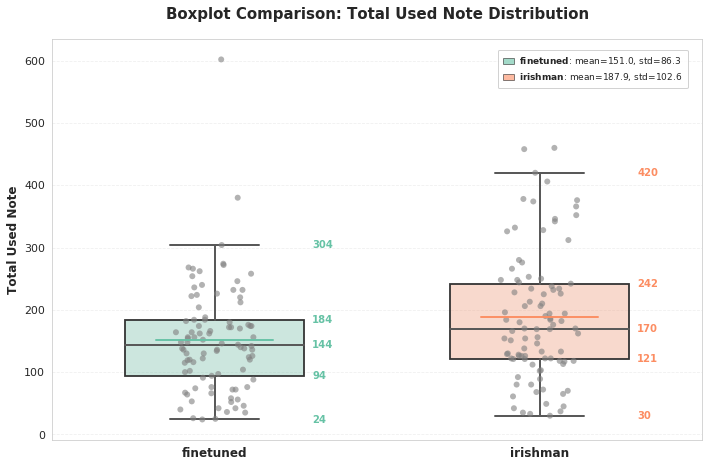

In [21]:
# Dados
data1 = set1_loaded_results['total_used_note'].flatten()
data2 = set2_loaded_results['total_used_note'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e r√≥tulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df = pd.DataFrame({
    'value': np.concatenate([data1, data2]),
    'model': np.array([labels[0]] * len(data1) + [labels[1]] * len(data2))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df[df['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da m√©dia com a cor do box (acima dos pontos)
means = df.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats = df.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df.loc[df['model'] == lbl, 'value'].values
    q1 = float(qstats.loc[lbl, 0.25])
    med = float(qstats.loc[lbl, 0.50])
    q3 = float(qstats.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme defini√ß√£o do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anota√ß√µes num√©ricas √† direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda alinhada √† direita no topo
stds = df.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means[labels[0]]), float(stds[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means[labels[1]]), float(stds[labels[1]]))
]
handles = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
           Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles, label_stats, loc='upper right', bbox_to_anchor=(0.985, 0.985), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X sim√©tricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# R√≥tulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Note', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Note Distribution', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

# Feature: `avg_IOI`

## Vis√£o Geral

A feature `avg_IOI` √© uma m√©trica musical que calcula o **intervalo m√©dio entre o in√≠cio de notas consecutivas** em uma pe√ßa musical. Esta funcionalidade est√° implementada na linha 320 do arquivo `core.py` do projeto mgeval.

## Conceito Musical

### IOI (Inter-Onset Interval)
- **Defini√ß√£o**: √â o tempo que passa entre o in√≠cio (onset) de uma nota e o in√≠cio da pr√≥xima nota
- **Unidade**: Geralmente medido em segundos ou beats
- **Import√¢ncia**: Fundamental para caracterizar o ritmo e timing musical

### Average IOI
- **Defini√ß√£o**: √â a m√©dia aritm√©tica de todos os intervalos IOI em uma pe√ßa musical
- **Prop√≥sito**: Fornece uma medida global da densidade temporal da m√∫sica

## Implementa√ß√£o T√©cnica

```python
def avg_IOI(self, feature):
    """
    avg_IOI (Average inter-onset-interval):
    To calculate the inter-onset-interval in the symbolic music domain, 
    we find the time between two consecutive notes.

    Returns:
    'avg_ioi': a scalar for each sample.
    """
    
    pm_object = feature['pretty_midi']
    onset = pm_object.get_onsets()      # Obt√©m todos os tempos de in√≠cio das notas
    ioi = np.diff(onset)                # Calcula as diferen√ßas entre onsets consecutivos
    avg_ioi = np.mean(ioi)              # Calcula a m√©dia dos intervalos
    return avg_ioi
```

## Passo a Passo do Algoritmo

1. **Extra√ß√£o dos Onsets**
   - Utiliza `pm_object.get_onsets()` para obter uma lista ordenada com todos os tempos de in√≠cio das notas
   - Os onsets s√£o extra√≠dos do objeto `pretty_midi` que cont√©m a representa√ß√£o musical

2. **C√°lculo dos Intervalos**
   - `np.diff(onset)` calcula a diferen√ßa entre cada par de onsets consecutivos
   - Resultado: array com os intervalos de tempo entre notas adjacentes

3. **C√°lculo da M√©dia**
   - `np.mean(ioi)` retorna a m√©dia aritm√©tica de todos os intervalos
   - Resultado final: um valor escalar representando o IOI m√©dio

## Interpreta√ß√£o Musical

### Valores Baixos de avg_IOI
- **Significado**: Notas mais pr√≥ximas no tempo
- **Caracter√≠sticas musicais**:
  - M√∫sica mais r√°pida
  - Maior densidade de notas
  - Ritmo mais acelerado
  - Poss√≠vel m√∫sica virtuos√≠stica ou energ√©tica

### Valores Altos de avg_IOI
- **Significado**: Notas mais espa√ßadas no tempo
- **Caracter√≠sticas musicais**:
  - M√∫sica mais lenta
  - Menor densidade de notas
  - Ritmo mais relaxado
  - Poss√≠vel m√∫sica contemplativa ou balada

## Aplica√ß√µes

### An√°lise Musical
- Caracteriza√ß√£o do **ritmo geral** de uma pe√ßa
- Medi√ß√£o da **densidade temporal** da m√∫sica
- Compara√ß√£o entre diferentes estilos musicais
- An√°lise de complexidade r√≠tmica

### Avalia√ß√£o de M√∫sica Gerada
- Valida√ß√£o da qualidade temporal de m√∫sica gerada por IA
- Compara√ß√£o entre diferentes modelos geradores
- M√©tricas de similaridade r√≠tmica com m√∫sica real

### Classifica√ß√£o Musical
- Feature para algoritmos de classifica√ß√£o de g√™nero
- An√°lise de padr√µes temporais por compositor
- Estudos de evolu√ß√£o hist√≥rica do ritmo musical

## Exemplo Conceitual

Considere uma sequ√™ncia de onsets: `[0.0, 0.5, 1.0, 1.25, 2.0]`

1. **IOIs calculados**: `[0.5, 0.5, 0.25, 0.75]`
2. **avg_IOI**: `(0.5 + 0.5 + 0.25 + 0.75) / 4 = 0.5 segundos`

Isso indicaria que, em m√©dia, h√° uma nova nota a cada 0.5 segundos.

## Limita√ß√µes e Considera√ß√µes

- **Polifonia**: A m√©trica considera todas as notas, independentemente de serem simult√¢neas
- **Pausas**: Intervalos longos (pausas) podem influenciar significativamente a m√©dia
- **Din√¢mica temporal**: N√£o captura varia√ß√µes de velocidade ao longo da m√∫sica
- **Contexto harm√¥nico**: N√£o considera aspectos harm√¥nicos, apenas temporais

## Rela√ß√£o com Outras M√©tricas

A `avg_IOI` complementa outras m√©tricas temporais como:
- Histograma de dura√ß√µes de notas
- Variabilidade r√≠tmica
- M√©tricas de sincroniza√ß√£o
- An√°lise de microritmo

# An√°lise Espec√≠fica da Feature avg_IOI (Average Inter-Onset Interval)

## Conceito da M√©trica

A feature `avg_IOI` (Average Inter-Onset Interval) mede o **intervalo m√©dio entre o in√≠cio de notas consecutivas** em uma pe√ßa musical. Esta m√©trica √© fundamental para caracterizar:

- **Densidade temporal** da m√∫sica
- **Ritmo geral** da composi√ß√£o  
- **Velocidade** de execu√ß√£o
- **Complexidade r√≠tmica**

### Interpreta√ß√£o dos Valores:
- **Valores baixos**: Notas mais pr√≥ximas no tempo (m√∫sica mais r√°pida/densa)
- **Valores altos**: Notas mais espa√ßadas no tempo (m√∫sica mais lenta/esparsa)

## Compara√ß√£o entre Modelos: {} vs {}

As visualiza√ß√µes a seguir comparam a distribui√ß√£o da feature `avg_IOI` entre os dois modelos.

In [25]:
# Extrair dados da feature avg_IOI
set1_avg_ioi = np.array(set1_loaded_results['avg_IOI']).flatten()
set2_avg_ioi = np.array(set2_loaded_results['avg_IOI']).flatten()

print("=== Estat√≠sticas Descritivas da Feature avg_IOI ===")
print("\nModelo 1 ({}):".format(MODEL_1))
print("  N√∫mero de amostras: {}".format(len(set1_avg_ioi)))
print("  M√©dia: {:.4f}".format(np.mean(set1_avg_ioi)))
print("  Mediana: {:.4f}".format(np.median(set1_avg_ioi)))
print("  Desvio Padr√£o: {:.4f}".format(np.std(set1_avg_ioi)))
print("  M√≠nimo: {:.4f}".format(np.min(set1_avg_ioi)))
print("  M√°ximo: {:.4f}".format(np.max(set1_avg_ioi)))

print("\nModelo 2 ({}):".format(MODEL_2))
print("  N√∫mero de amostras: {}".format(len(set2_avg_ioi)))
print("  M√©dia: {:.4f}".format(np.mean(set2_avg_ioi)))
print("  Mediana: {:.4f}".format(np.median(set2_avg_ioi)))
print("  Desvio Padr√£o: {:.4f}".format(np.std(set2_avg_ioi)))
print("  M√≠nimo: {:.4f}".format(np.min(set2_avg_ioi)))
print("  M√°ximo: {:.4f}".format(np.max(set2_avg_ioi)))

print("\n=== Compara√ß√£o Direta ===")
diff_media = np.mean(set1_avg_ioi) - np.mean(set2_avg_ioi)
print("Diferen√ßa nas m√©dias ({} - {}): {:.4f}".format(MODEL_1, MODEL_2, diff_media))
if diff_media > 0:
    print("‚Üí O modelo {} produz m√∫sica com intervalos ligeiramente maiores (mais espa√ßada)".format(MODEL_1))
elif diff_media < 0:
    print("‚Üí O modelo {} produz m√∫sica com intervalos ligeiramente menores (mais densa)".format(MODEL_1))
else:
    print("‚Üí Ambos os modelos produzem m√∫sica com intervalos similares")

=== Estat√≠sticas Descritivas da Feature avg_IOI ===

Modelo 1 (finetuned):
  N√∫mero de amostras: 93
  M√©dia: 0.3667
  Mediana: 0.3485
  Desvio Padr√£o: 0.1204
  M√≠nimo: 0.1371
  M√°ximo: 0.8099

Modelo 2 (irishman):
  N√∫mero de amostras: 93
  M√©dia: 0.3059
  Mediana: 0.2712
  Desvio Padr√£o: 0.1317
  M√≠nimo: 0.1526
  M√°ximo: 1.2083

=== Compara√ß√£o Direta ===
Diferen√ßa nas m√©dias (finetuned - irishman): 0.0608
‚Üí O modelo finetuned produz m√∫sica com intervalos ligeiramente maiores (mais espa√ßada)


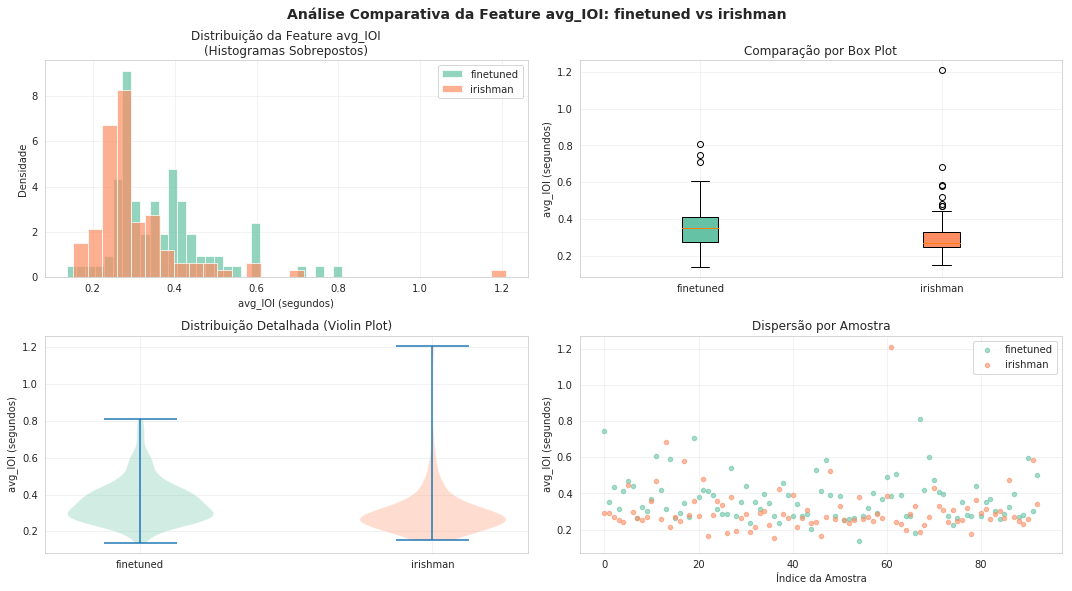


=== Interpreta√ß√£o das Distribui√ß√µes ===
Coeficiente de Varia√ß√£o (finetuned)  : 0.328
Coeficiente de Varia√ß√£o (irishman): 0.431

Um coeficiente menor indica maior consist√™ncia r√≠tmica.


In [27]:
# Visualiza√ß√£o 1: Histogramas Comparativos da Feature avg_IOI
colors = ['#66c2a5', '#fc8d62']  # MODEL_1, MODEL_2

plt.figure(figsize=(15, 8))

# Subplot 1: Histogramas sobrepostos
plt.subplot(2, 2, 1)
plt.hist(set1_avg_ioi, bins=30, alpha=0.7, label=MODEL_1, color=colors[0], density=True)
plt.hist(set2_avg_ioi, bins=30, alpha=0.7, label=MODEL_2, color=colors[1], density=True)
plt.xlabel('avg_IOI (segundos)')
plt.ylabel('Densidade')
plt.title('Distribui√ß√£o da Feature avg_IOI\n(Histogramas Sobrepostos)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Box plots comparativos
plt.subplot(2, 2, 2)
data_for_boxplot = [set1_avg_ioi, set2_avg_ioi]
labels_for_boxplot = [MODEL_1, MODEL_2]
bp = plt.boxplot(data_for_boxplot, labels=labels_for_boxplot, patch_artist=True)
bp['boxes'][0].set_facecolor(colors[0])
bp['boxes'][1].set_facecolor(colors[1])
plt.ylabel('avg_IOI (segundos)')
plt.title('Compara√ß√£o por Box Plot')
plt.grid(True, alpha=0.3)

# Subplot 3: Violin plots
plt.subplot(2, 2, 3)
parts = plt.violinplot([set1_avg_ioi, set2_avg_ioi], positions=[1, 2])
parts['bodies'][0].set_facecolor(colors[0])
parts['bodies'][1].set_facecolor(colors[1])
plt.xticks([1, 2], [MODEL_1, MODEL_2])
plt.ylabel('avg_IOI (segundos)')
plt.title('Distribui√ß√£o Detalhada (Violin Plot)')
plt.grid(True, alpha=0.3)

# Subplot 4: Scatter plot comparativo (√≠ndices vs valores)
plt.subplot(2, 2, 4)
indices1 = range(len(set1_avg_ioi))
indices2 = range(len(set2_avg_ioi))
plt.scatter(indices1, set1_avg_ioi, alpha=0.6, label=MODEL_1, color=colors[0], s=20)
plt.scatter(indices2, set2_avg_ioi, alpha=0.6, label=MODEL_2, color=colors[1], s=20)
plt.xlabel('√çndice da Amostra')
plt.ylabel('avg_IOI (segundos)')
plt.title('Dispers√£o por Amostra')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('An√°lise Comparativa da Feature avg_IOI: {} vs {}'.format(MODEL_1, MODEL_2), 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Estat√≠sticas adicionais para interpreta√ß√£o
print("\n=== Interpreta√ß√£o das Distribui√ß√µes ===")
print("Coeficiente de Varia√ß√£o ({})  : {:.3f}".format(MODEL_1, np.std(set1_avg_ioi)/np.mean(set1_avg_ioi)))
print("Coeficiente de Varia√ß√£o ({}): {:.3f}".format(MODEL_2, np.std(set2_avg_ioi)/np.mean(set2_avg_ioi)))
print("\nUm coeficiente menor indica maior consist√™ncia r√≠tmica.")

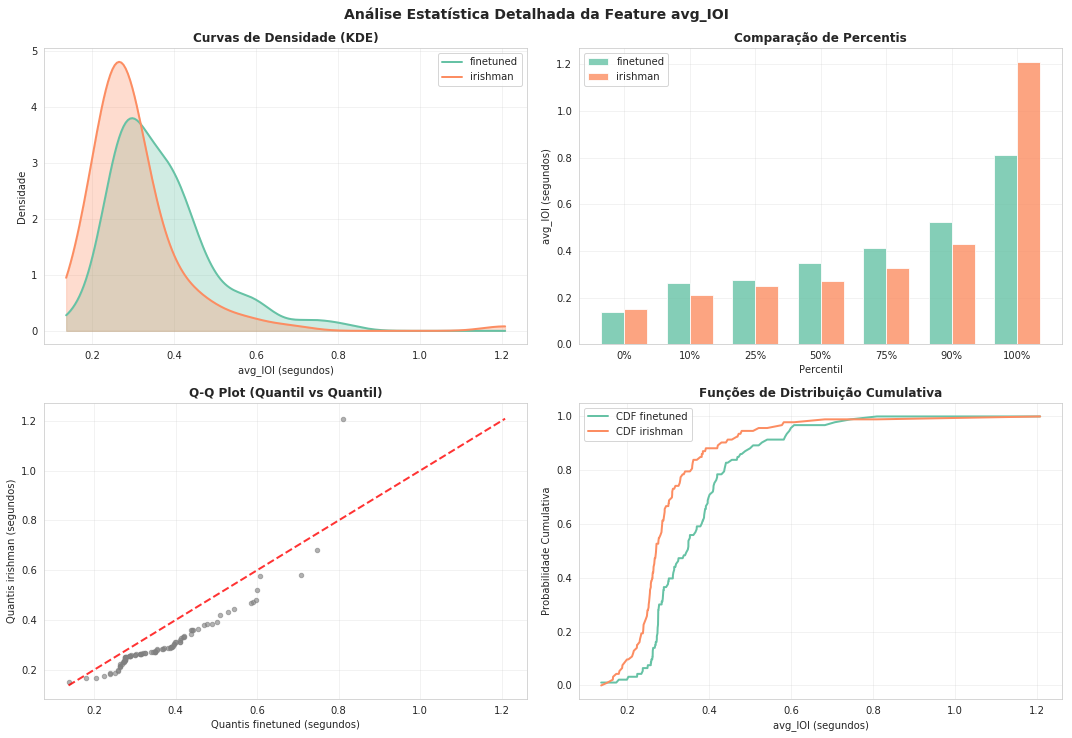

In [32]:
# Visualiza√ß√£o 2: An√°lise de Densidade e Compara√ß√£o Detalhada
colors = ['#66c2a5', '#fc8d62']  # MODEL_1, MODEL_2

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gr√°fico 1: Curvas de densidade (KDE)
axes[0, 0].set_title('Curvas de Densidade (KDE)', fontweight='bold')
try:
    from scipy import stats
    
    # Criar range para o KDE
    all_values = np.concatenate([set1_avg_ioi, set2_avg_ioi])
    x_range = np.linspace(all_values.min(), all_values.max(), 200)
    
    # KDE para set1
    kde1 = stats.gaussian_kde(set1_avg_ioi)
    density1 = kde1(x_range)
    axes[0, 0].plot(x_range, density1, label=MODEL_1, color=colors[0], linewidth=2)
    
    # KDE para set2
    kde2 = stats.gaussian_kde(set2_avg_ioi)
    density2 = kde2(x_range)
    axes[0, 0].plot(x_range, density2, label=MODEL_2, color=colors[1], linewidth=2)
    
    axes[0, 0].fill_between(x_range, density1, alpha=0.3, color=colors[0])
    axes[0, 0].fill_between(x_range, density2, alpha=0.3, color=colors[1])
    
except ImportError:
    # Fallback se scipy n√£o estiver dispon√≠vel
    axes[0, 0].hist(set1_avg_ioi, bins=30, alpha=0.5, label=MODEL_1, density=True, color=colors[0])
    axes[0, 0].hist(set2_avg_ioi, bins=30, alpha=0.5, label=MODEL_2, density=True, color=colors[1])

axes[0, 0].set_xlabel('avg_IOI (segundos)')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gr√°fico 2: Compara√ß√£o de percentis
axes[0, 1].set_title('Compara√ß√£o de Percentis', fontweight='bold')
percentis = [0, 10, 25, 50, 75, 90, 100]
values1 = [np.percentile(set1_avg_ioi, p) for p in percentis]
values2 = [np.percentile(set2_avg_ioi, p) for p in percentis]

x_pos = np.arange(len(percentis))
width = 0.35
axes[0, 1].bar(x_pos - width/2, values1, width, label=MODEL_1, color=colors[0], alpha=0.8)
axes[0, 1].bar(x_pos + width/2, values2, width, label=MODEL_2, color=colors[1], alpha=0.8)
axes[0, 1].set_xlabel('Percentil')
axes[0, 1].set_ylabel('avg_IOI (segundos)')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['{}%'.format(p) for p in percentis])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gr√°fico 3: Q-Q Plot (compara√ß√£o de distribui√ß√µes)
axes[1, 0].set_title('Q-Q Plot (Quantil vs Quantil)', fontweight='bold')
# Ordenar os dados
sorted1 = np.sort(set1_avg_ioi)
sorted2 = np.sort(set2_avg_ioi)

# Interpolar para ter o mesmo n√∫mero de pontos
min_len = min(len(sorted1), len(sorted2))
if len(sorted1) > min_len:
    indices1 = np.linspace(0, len(sorted1)-1, min_len).astype(int)
    sorted1 = sorted1[indices1]
if len(sorted2) > min_len:
    indices2 = np.linspace(0, len(sorted2)-1, min_len).astype(int)
    sorted2 = sorted2[indices2]

axes[1, 0].scatter(sorted1, sorted2, alpha=0.6, s=20, color='gray')
# Linha de refer√™ncia (y=x)
min_val = min(sorted1.min(), sorted2.min())
max_val = max(sorted1.max(), sorted2.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
axes[1, 0].set_xlabel('Quantis {} (segundos)'.format(MODEL_1))
axes[1, 0].set_ylabel('Quantis {} (segundos)'.format(MODEL_2))
axes[1, 0].grid(True, alpha=0.3)

# Gr√°fico 4: Diferen√ßa cumulativa
axes[1, 1].set_title('Fun√ß√µes de Distribui√ß√£o Cumulativa', fontweight='bold')
# CDF emp√≠rica
sorted_all = np.sort(np.concatenate([set1_avg_ioi, set2_avg_ioi]))
cdf1 = np.searchsorted(np.sort(set1_avg_ioi), sorted_all, side='right') / float(len(set1_avg_ioi))
cdf2 = np.searchsorted(np.sort(set2_avg_ioi), sorted_all, side='right') / float(len(set2_avg_ioi))

axes[1, 1].plot(sorted_all, cdf1, label='CDF {}'.format(MODEL_1), color=colors[0], linewidth=2)
axes[1, 1].plot(sorted_all, cdf2, label='CDF {}'.format(MODEL_2), color=colors[1], linewidth=2)
axes[1, 1].set_xlabel('avg_IOI (segundos)')
axes[1, 1].set_ylabel('Probabilidade Cumulativa')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('An√°lise Estat√≠stica Detalhada da Feature avg_IOI', y=1.02, fontsize=14, fontweight='bold')
plt.show()

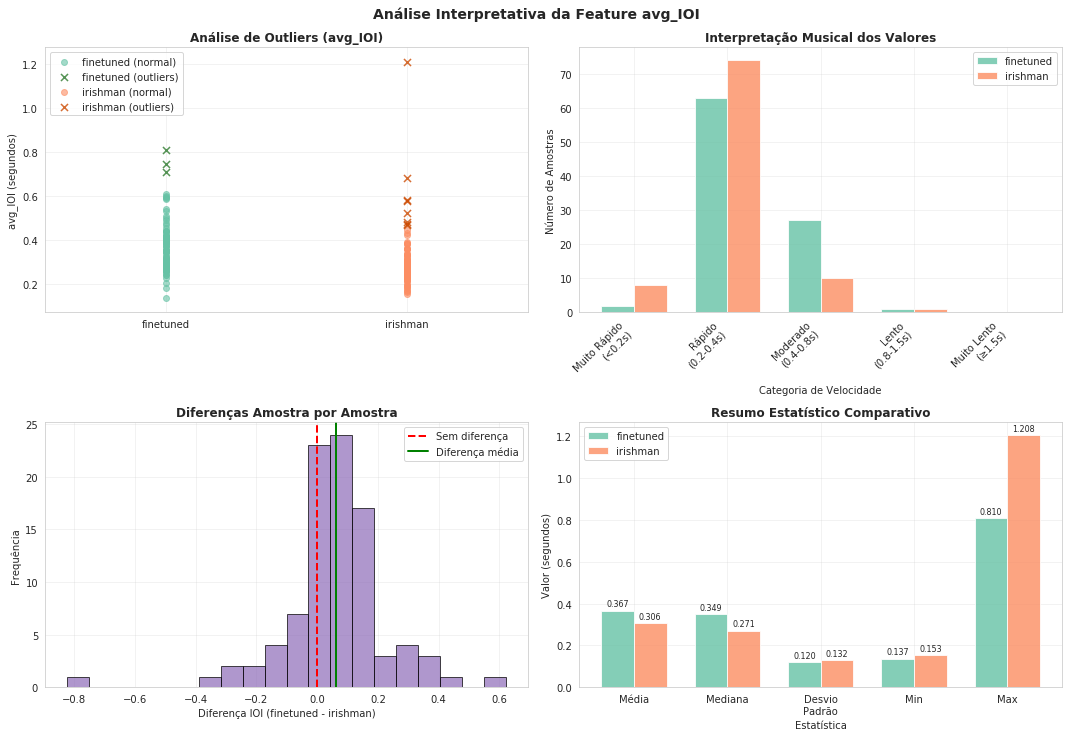


RELAT√ìRIO DE AN√ÅLISE - FEATURE avg_IOI

OUTLIERS IDENTIFICADOS:
  finetuned: 3 outliers de 93 amostras (3.0%)
  irishman: 8 outliers de 93 amostras (8.0%)

CATEGORIZA√á√ÉO MUSICAL:
  Muito R√°pido (<0.2s): 2 vs 8 (2.0% vs 8.0%)
  R√°pido (0.2-0.4s): 63 vs 74 (67.0% vs 79.0%)
  Moderado (0.4-0.8s): 27 vs 10 (29.0% vs 10.0%)
  Lento (0.8-1.5s): 1 vs 1 (1.0% vs 1.0%)
  Muito Lento (‚â•1.5s): 0 vs 0 (0.0% vs 0.0%)

DIFEREN√áAS ENTRE MODELOS:
  Diferen√ßa m√©dia: 0.0608 segundos
  Amostras onde finetuned > irishman: 75.0%



In [31]:
# Visualiza√ß√£o 3: An√°lise de Outliers e Interpreta√ß√£o Musical
colors = ['#66c2a5', '#fc8d62']  # MODEL_1, MODEL_2

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gr√°fico 1: Identifica√ß√£o de outliers
axes[0, 0].set_title('An√°lise de Outliers (avg_IOI)', fontweight='bold')

# Calcular quartis e IQR para identificar outliers
def identify_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers1, lb1, ub1 = identify_outliers(set1_avg_ioi)
outliers2, lb2, ub2 = identify_outliers(set2_avg_ioi)

# Plot dos dados normais e outliers
normal1 = set1_avg_ioi[(set1_avg_ioi >= lb1) & (set1_avg_ioi <= ub1)]
normal2 = set2_avg_ioi[(set2_avg_ioi >= lb2) & (set2_avg_ioi <= ub2)]

axes[0, 0].scatter(np.ones(len(normal1)), normal1, alpha=0.6, color=colors[0], label='{} (normal)'.format(MODEL_1))
axes[0, 0].scatter(np.ones(len(outliers1)), outliers1, alpha=0.8, color='#2d7a2d', marker='x', s=50, label='{} (outliers)'.format(MODEL_1))
axes[0, 0].scatter(2*np.ones(len(normal2)), normal2, alpha=0.6, color=colors[1], label='{} (normal)'.format(MODEL_2))
axes[0, 0].scatter(2*np.ones(len(outliers2)), outliers2, alpha=0.8, color='#cc4a00', marker='x', s=50, label='{} (outliers)'.format(MODEL_2))

axes[0, 0].set_xlim(0.5, 2.5)
axes[0, 0].set_xticks([1, 2])
axes[0, 0].set_xticklabels([MODEL_1, MODEL_2])
axes[0, 0].set_ylabel('avg_IOI (segundos)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gr√°fico 2: Categoriza√ß√£o musical dos valores
axes[0, 1].set_title('Interpreta√ß√£o Musical dos Valores', fontweight='bold')

# Definir categorias baseadas nos valores t√≠picos de IOI
def categorize_tempo(ioi_values):
    # Categorias baseadas em intervalos t√≠picos de m√∫sica
    very_fast = (ioi_values < 0.2).sum()      # < 0.2s (muito r√°pido)
    fast = ((ioi_values >= 0.2) & (ioi_values < 0.4)).sum()       # 0.2-0.4s (r√°pido)
    moderate = ((ioi_values >= 0.4) & (ioi_values < 0.8)).sum()   # 0.4-0.8s (moderado)
    slow = ((ioi_values >= 0.8) & (ioi_values < 1.5)).sum()       # 0.8-1.5s (lento)
    very_slow = (ioi_values >= 1.5).sum()     # >= 1.5s (muito lento)
    
    return [very_fast, fast, moderate, slow, very_slow]

categories = ['Muito R√°pido\n(<0.2s)', 'R√°pido\n(0.2-0.4s)', 'Moderado\n(0.4-0.8s)', 'Lento\n(0.8-1.5s)', 'Muito Lento\n(‚â•1.5s)']
counts1 = categorize_tempo(set1_avg_ioi)
counts2 = categorize_tempo(set2_avg_ioi)

x_pos = np.arange(len(categories))
width = 0.35
axes[0, 1].bar(x_pos - width/2, counts1, width, label=MODEL_1, color=colors[0], alpha=0.8)
axes[0, 1].bar(x_pos + width/2, counts2, width, label=MODEL_2, color=colors[1], alpha=0.8)
axes[0, 1].set_xlabel('Categoria de Velocidade')
axes[0, 1].set_ylabel('N√∫mero de Amostras')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(categories, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gr√°fico 3: Compara√ß√£o direta (diferen√ßas)
axes[1, 0].set_title('Diferen√ßas Amostra por Amostra', fontweight='bold')
min_samples = min(len(set1_avg_ioi), len(set2_avg_ioi))
if min_samples > 0:
    differences = set1_avg_ioi[:min_samples] - set2_avg_ioi[:min_samples]
    axes[1, 0].hist(differences, bins=20, alpha=0.7, color='#8d6bb8', edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Sem diferen√ßa')
    axes[1, 0].axvline(x=np.mean(differences), color='green', linestyle='-', linewidth=2, label='Diferen√ßa m√©dia')
    axes[1, 0].set_xlabel('Diferen√ßa IOI ({} - {})'.format(MODEL_1, MODEL_2))
    axes[1, 0].set_ylabel('Frequ√™ncia')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'N√£o h√° amostras suficientes\npara compara√ß√£o direta', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)

# Gr√°fico 4: Resumo estat√≠stico visual
axes[1, 1].set_title('Resumo Estat√≠stico Comparativo', fontweight='bold')
stats_labels = ['M√©dia', 'Mediana', 'Desvio\nPadr√£o', 'Min', 'Max']
stats1 = [np.mean(set1_avg_ioi), np.median(set1_avg_ioi), np.std(set1_avg_ioi), 
          np.min(set1_avg_ioi), np.max(set1_avg_ioi)]
stats2 = [np.mean(set2_avg_ioi), np.median(set2_avg_ioi), np.std(set2_avg_ioi), 
          np.min(set2_avg_ioi), np.max(set2_avg_ioi)]

x_pos = np.arange(len(stats_labels))
width = 0.35
bars1 = axes[1, 1].bar(x_pos - width/2, stats1, width, label=MODEL_1, color=colors[0], alpha=0.8)
bars2 = axes[1, 1].bar(x_pos + width/2, stats2, width, label=MODEL_2, color=colors[1], alpha=0.8)

# Adicionar valores nas barras
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[1, 1].text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                    '{:.3f}'.format(stats1[i]), ha='center', va='bottom', fontsize=8)
    axes[1, 1].text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01,
                    '{:.3f}'.format(stats2[i]), ha='center', va='bottom', fontsize=8)

axes[1, 1].set_xlabel('Estat√≠stica')
axes[1, 1].set_ylabel('Valor (segundos)')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stats_labels)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('An√°lise Interpretativa da Feature avg_IOI', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Relat√≥rio resumido
print("\n" + "="*60)
print("RELAT√ìRIO DE AN√ÅLISE - FEATURE avg_IOI")
print("="*60)
print("\nOUTLIERS IDENTIFICADOS:")
print("  {}: {} outliers de {} amostras ({:.1f}%)".format(MODEL_1, len(outliers1), len(set1_avg_ioi), 100*len(outliers1)/len(set1_avg_ioi)))
print("  {}: {} outliers de {} amostras ({:.1f}%)".format(MODEL_2, len(outliers2), len(set2_avg_ioi), 100*len(outliers2)/len(set2_avg_ioi)))

print("\nCATEGORIZA√á√ÉO MUSICAL:")
for i, cat in enumerate(categories):
    print("  {}: {} vs {} ({:.1f}% vs {:.1f}%)".format(
        cat.replace('\n', ' '), counts1[i], counts2[i], 
        100*counts1[i]/len(set1_avg_ioi), 100*counts2[i]/len(set2_avg_ioi)))

if min_samples > 0:
    print("\nDIFEREN√áAS ENTRE MODELOS:")
    print("  Diferen√ßa m√©dia: {:.4f} segundos".format(np.mean(differences)))
    print("  Amostras onde {} > {}: {:.1f}%".format(MODEL_1, MODEL_2, 100*np.sum(differences > 0)/len(differences)))
    
print("\n" + "="*60)

## Interpreta√ß√£o e Conclus√µes da An√°lise avg_IOI

### O que as visualiza√ß√µes mostram:

1. **Distribui√ß√£o Geral**: Os histogramas e curvas de densidade revelam como cada modelo distribui os intervalos entre notas
2. **Variabilidade**: Box plots e violin plots mostram a dispers√£o e presen√ßa de valores extremos
3. **Outliers**: Identifica√ß√£o de composi√ß√µes com caracter√≠sticas r√≠tmicas incomuns
4. **Categoriza√ß√£o Musical**: Classifica√ß√£o das composi√ß√µes em termos de velocidade/densidade
5. **Compara√ß√£o Direta**: Diferen√ßas sistem√°ticas entre os modelos

### Significado Musical:

- **avg_IOI baixo** (< 0.4s): M√∫sica mais densa, r√°pida, possivelmente virtuos√≠stica
- **avg_IOI m√©dio** (0.4-0.8s): M√∫sica de andamento moderado, t√≠pica de muitos g√™neros
- **avg_IOI alto** (> 0.8s): M√∫sica mais espa√ßada, contemplativa ou minimalista

### Implica√ß√µes para Avalia√ß√£o de Modelos:

- **Consist√™ncia**: Menor variabilidade pode indicar maior controle do modelo
- **Naturalidade**: Distribui√ß√£o similar √† m√∫sica real sugere melhor qualidade
- **Diversidade**: Capacidade de gerar diferentes estilos de densidade temporal

Esta an√°lise da feature `avg_IOI` complementa outras m√©tricas para uma avalia√ß√£o completa da qualidade musical dos modelos gerativos.